<a href="https://colab.research.google.com/github/Kim-Ye-Chan/Amber/blob/main/Wellmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚔️  Wellmax vs AdamW: 진검승부 시작 (Rosenbrock Valley) ⚔️


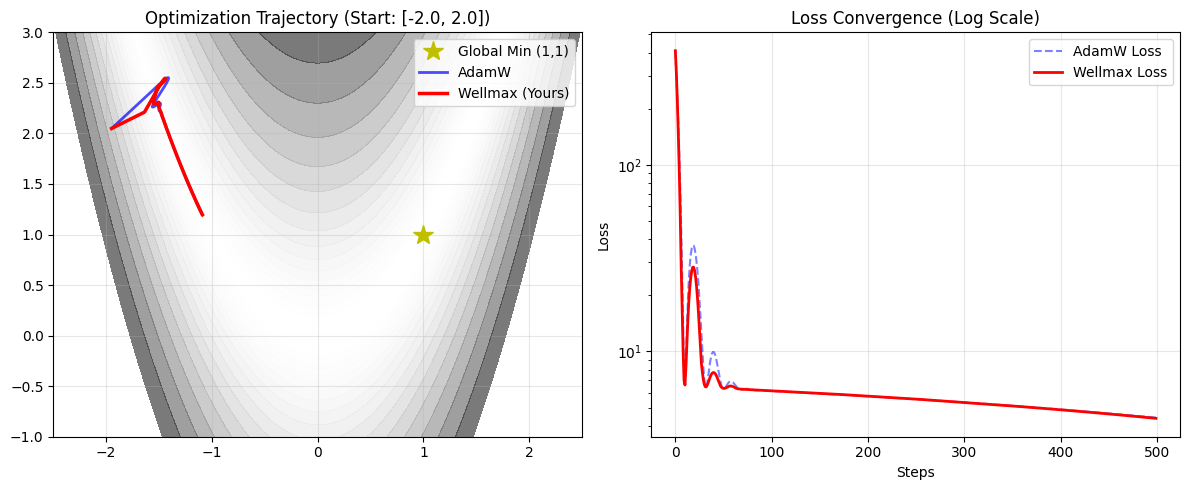

Final Loss - AdamW: 4.417659
Final Loss - Wellmax: 4.378657


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Optimizer, AdamW

# -----------------------------------------------------------
# 1. Wellmax Optimizer Class (자네의 최종 완성본)
# -----------------------------------------------------------
class Wellmax(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        if lr < 0.0: raise ValueError("Invalid lr: {}".format(lr))
        if eps < 0.0: raise ValueError("Invalid eps: {}".format(eps))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super(Wellmax, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad(): loss = closure()

        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]

                # Init
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']

                # Adam Core
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1 - beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom

                # Weight Decay
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                # Wellmax Logic (Orthogonal Exploration)
                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())

                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel

                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)

                    lateral = orth * (adam_norm / orth_norm) * gamma

                    # Clipping
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat:
                        lateral.mul_(max_lat / (lateral.norm() + 1e-12))

                    update = adam_step + lateral

                p.data.add_(update, alpha=-step_size)
        return loss

# -----------------------------------------------------------
# 2. Test Setup: Rosenbrock Function (The Banana Valley)
#    f(x, y) = (1 - x)^2 + 100 * (y - x^2)^2
#    Global Minimum at (1, 1)
# -----------------------------------------------------------
def rosenbrock(tensor):
    x, y = tensor[0], tensor[1]
    return (1 - x)**2 + 100 * (y - x**2)**2

def run_optimizer(optim_class, name, color, start_pos, steps=300, **kwargs):
    # Starting Point (난이도 높음: -2, 2)
    params = torch.tensor(start_pos, requires_grad=True, dtype=torch.float32)
    optimizer = optim_class([params], **kwargs)

    path_x, path_y = [], []
    losses = []

    for _ in range(steps):
        optimizer.zero_grad()
        loss = rosenbrock(params)
        loss.backward()
        optimizer.step()

        path_x.append(params[0].item())
        path_y.append(params[1].item())
        losses.append(loss.item())

    return path_x, path_y, losses

# -----------------------------------------------------------
# 3. Execution & Visualization
# -----------------------------------------------------------
print("⚔️  Wellmax vs AdamW: 진검승부 시작 (Rosenbrock Valley) ⚔️")

start_pos = [-2.0, 2.0] # 골짜기 멀리서 시작
steps = 500
lr = 0.05 # 학습률을 좀 키워서 거동을 확인

# AdamW 실행
adam_x, adam_y, adam_loss = run_optimizer(AdamW, "AdamW", "blue", start_pos, steps, lr=lr)

# Wellmax 실행 (Gamma 0.3으로 약간 공격적인 탐색 부여)
well_x, well_y, well_loss = run_optimizer(Wellmax, "Wellmax", "red", start_pos, steps, lr=lr, gamma=0.3)

# --- Plotting ---
plt.figure(figsize=(12, 5))

# Plot 1: Trajectory on Contour Map
plt.subplot(1, 2, 1)
x = np.linspace(-2.5, 2.5, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = (1 - X)**2 + 100 * (Y - X**2)**2

plt.contourf(X, Y, Z, levels=np.logspace(-1, 3, 30), cmap='gray_r', alpha=0.6)
plt.plot(1, 1, 'y*', markersize=15, label='Global Min (1,1)') # 목표지점

plt.plot(adam_x, adam_y, 'b-', label='AdamW', linewidth=2, alpha=0.7)
plt.plot(well_x, well_y, 'r-', label='Wellmax (Yours)', linewidth=2.5)
plt.title(f"Optimization Trajectory (Start: {start_pos})")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Loss Curve
plt.subplot(1, 2, 2)
plt.plot(adam_loss, 'b--', label='AdamW Loss', alpha=0.5)
plt.plot(well_loss, 'r-', label='Wellmax Loss', linewidth=2)
plt.yscale('log')
plt.title("Loss Convergence (Log Scale)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Loss - AdamW: {adam_loss[-1]:.6f}")
print(f"Final Loss - Wellmax: {well_loss[-1]:.6f}")


🔬 실험 환경 가동: cpu (Wellmax 준비 완료)


100%|██████████| 9.91M/9.91M [00:00<00:00, 59.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.75MB/s]



🚀 [AdamW] 학습 시작...
   Ep 1: Loss 0.2986 | Acc 95.22%
   Ep 2: Loss 0.1279 | Acc 96.79%
   Ep 3: Loss 0.0884 | Acc 97.25%
   Ep 4: Loss 0.0690 | Acc 97.10%
   Ep 5: Loss 0.0530 | Acc 97.61%
🏁 [AdamW] 완료 (92.2초)

🚀 [Wellmax] 학습 시작...
   Ep 1: Loss 0.2928 | Acc 95.40%
   Ep 2: Loss 0.1273 | Acc 96.79%
   Ep 3: Loss 0.0877 | Acc 97.13%
   Ep 4: Loss 0.0682 | Acc 97.37%
   Ep 5: Loss 0.0529 | Acc 97.73%
🏁 [Wellmax] 완료 (94.6초)


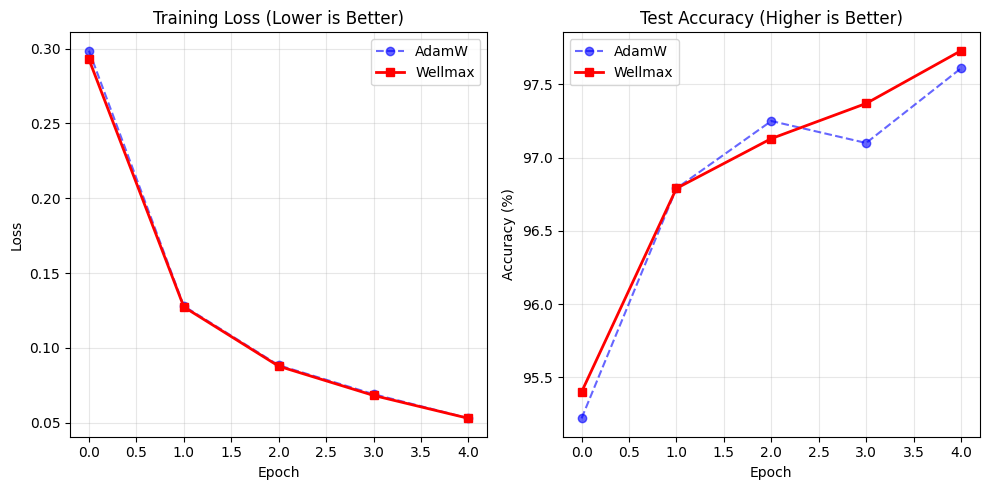


📊 최종 스코어 (Epoch 5)
AdamW  : Loss 0.0530 | Acc 97.61%
Wellmax: Loss 0.0529 | Acc 97.73%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# 📱 스마트폰/Colab 환경 최적화 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔬 실험 환경 가동: {device} (Wellmax 준비 완료)")

# ---------------------------------------------------
# 1. 데이터 & 모델 준비 (가볍고 빠른 MNIST)
# ---------------------------------------------------
# 데이터셋 다운로드 및 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST('./data', train=False, transform=transform)

# 배치를 좀 키워서 속도를 높임 (스마트폰 발열 방지)
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

# 가벼운 MLP 모델 (784 -> 128 -> 10)
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ---------------------------------------------------
# 2. 공정한 실험 함수 (The Arena)
# ---------------------------------------------------
def train_and_evaluate(optimizer_cls, name, color, **optim_kwargs):
    # 시드 고정 (똑같은 파라미터 초기값에서 시작하기 위함)
    torch.manual_seed(42)
    model = SimpleNet().to(device)

    optimizer = optimizer_cls(model.parameters(), **optim_kwargs)
    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []

    print(f"\n🚀 [{name}] 학습 시작...")
    start_time = time.time()

    epochs = 5 # 폰이라서 5 epoch면 충분함

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # 평가
        model.eval()
        correct = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x).argmax(dim=1)
                correct += pred.eq(y).sum().item()

        avg_loss = epoch_loss / len(train_loader)
        acc = 100. * correct / len(test_loader.dataset)

        losses.append(avg_loss)
        accuracies.append(acc)
        print(f"   Ep {epoch+1}: Loss {avg_loss:.4f} | Acc {acc:.2f}%")

    duration = time.time() - start_time
    print(f"🏁 [{name}] 완료 ({duration:.1f}초)")
    return losses, accuracies

# ---------------------------------------------------
# 3. 실험 실행 (Battle Start!)
# ---------------------------------------------------
# Hyperparams
lr = 0.002  # 조금 빠른 학습을 위해
wd = 0.01

# A. AdamW (Baseline)
adam_loss, adam_acc = train_and_evaluate(
    torch.optim.AdamW, "AdamW", "blue",
    lr=lr, weight_decay=wd
)

# B. Wellmax (Challenger) - gamma 0.1 (표준 탐색)
well_loss, well_acc = train_and_evaluate(
    Wellmax, "Wellmax", "red",
    lr=lr, weight_decay=wd, gamma=0.1, curl_clip=1.0
)

# ---------------------------------------------------
# 4. 결과 시각화 (모바일 가독성 최적화)
# ---------------------------------------------------
plt.figure(figsize=(10, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(adam_loss, 'b--o', label='AdamW', alpha=0.6)
plt.plot(well_loss, 'r-s', label='Wellmax', linewidth=2)
plt.title('Training Loss (Lower is Better)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(adam_acc, 'b--o', label='AdamW', alpha=0.6)
plt.plot(well_acc, 'r-s', label='Wellmax', linewidth=2)
plt.title('Test Accuracy (Higher is Better)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 최종 스코어 (Epoch 5)")
print(f"AdamW  : Loss {adam_loss[-1]:.4f} | Acc {adam_acc[-1]:.2f}%")
print(f"Wellmax: Loss {well_loss[-1]:.4f} | Acc {well_acc[-1]:.2f}%")


🔬 실험 환경: cuda (CIFAR-10 Ready)


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]



🏎️ [AdamW] Start!
   Ep 1: Loss 1.3778 | Acc 61.18%
   Ep 2: Loss 0.9428 | Acc 68.69%
   Ep 3: Loss 0.7620 | Acc 72.77%
   Ep 4: Loss 0.6392 | Acc 73.51%
   Ep 5: Loss 0.5310 | Acc 74.30%
   Ep 6: Loss 0.4417 | Acc 73.93%
   Ep 7: Loss 0.3562 | Acc 75.25%
   Ep 8: Loss 0.2738 | Acc 75.01%
   Ep 9: Loss 0.2201 | Acc 75.13%
   Ep 10: Loss 0.1626 | Acc 75.11%
🏁 Done (139.3s)

🏎️ [Wellmax] Start!
   Ep 1: Loss 1.3530 | Acc 60.80%
   Ep 2: Loss 0.9331 | Acc 68.17%
   Ep 3: Loss 0.7574 | Acc 72.90%
   Ep 4: Loss 0.6340 | Acc 74.67%
   Ep 5: Loss 0.5291 | Acc 75.82%
   Ep 6: Loss 0.4396 | Acc 75.31%
   Ep 7: Loss 0.3598 | Acc 75.55%
   Ep 8: Loss 0.2798 | Acc 75.38%
   Ep 9: Loss 0.2198 | Acc 76.32%
   Ep 10: Loss 0.1706 | Acc 75.97%
🏁 Done (153.7s)


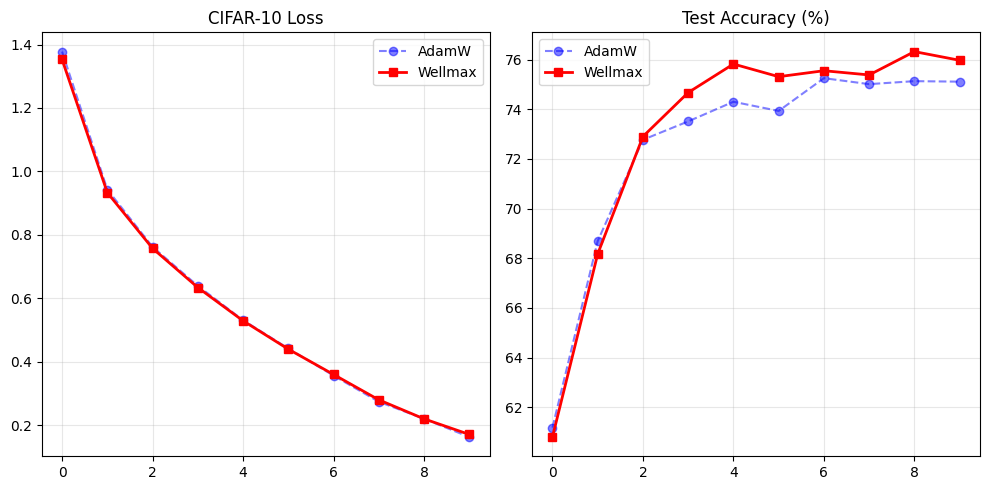


📊 Final Acc -> AdamW: 75.11% vs Wellmax: 75.97%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Optimizer
import matplotlib.pyplot as plt
import time

# 📱 1. Setup & Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔬 실험 환경: {device} (CIFAR-10 Ready)")

# -----------------------------------------------------------
# 2. Wellmax Optimizer (Your Algorithm)
# -----------------------------------------------------------
class Wellmax(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super(Wellmax, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad(): loss = closure()

        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']

                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1 - beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom

                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())

                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel

                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)

                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat:
                        lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral

                p.data.add_(update, alpha=-step_size)
        return loss

# -----------------------------------------------------------
# 3. Data & CNN Model (Simple but effective)
# -----------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_ds = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_ds = datasets.CIFAR10('./data', train=False, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2) # 폰 환경 고려
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

class QuickCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv -> Relu -> Pool 구조 3번 반복
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# -----------------------------------------------------------
# 4. Training Loop (Compact)
# -----------------------------------------------------------
def run_experiment(optim_cls, name, epochs=10, **kwargs):
    torch.manual_seed(42) # 공정한 출발선
    model = QuickCNN().to(device)
    optimizer = optim_cls(model.parameters(), **kwargs)
    criterion = nn.CrossEntropyLoss()

    losses, accs = [], []
    print(f"\n🏎️ [{name}] Start!")
    start = time.time()

    for ep in range(epochs):
        model.train()
        sum_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()

        model.eval()
        correct = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                correct += model(x).argmax(1).eq(y).sum().item()

        avg_loss = sum_loss / len(train_loader)
        acc = 100 * correct / len(test_ds)
        losses.append(avg_loss)
        accs.append(acc)
        print(f"   Ep {ep+1}: Loss {avg_loss:.4f} | Acc {acc:.2f}%")

    print(f"🏁 Done ({time.time()-start:.1f}s)")
    return losses, accs

# -----------------------------------------------------------
# 5. Execute
# -----------------------------------------------------------
epochs = 10
lr = 1e-3
wd = 1e-4

# A. AdamW
adam_loss, adam_acc = run_experiment(torch.optim.AdamW, "AdamW", epochs, lr=lr, weight_decay=wd)

# B. Wellmax (Gamma 0.1)
well_loss, well_acc = run_experiment(Wellmax, "Wellmax", epochs, lr=lr, weight_decay=wd, gamma=0.1, curl_clip=1.0)

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(adam_loss, 'b--o', label='AdamW', alpha=0.5)
plt.plot(well_loss, 'r-s', label='Wellmax', linewidth=2)
plt.title('CIFAR-10 Loss')
plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(adam_acc, 'b--o', label='AdamW', alpha=0.5)
plt.plot(well_acc, 'r-s', label='Wellmax', linewidth=2)
plt.title('Test Accuracy (%)')
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Final Acc -> AdamW: {adam_acc[-1]:.2f}% vs Wellmax: {well_acc[-1]:.2f}%")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import math

# ------------------------------------------------------------------------------
# [0] Configuration
# ------------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Computation Device: {DEVICE}")

# ------------------------------------------------------------------------------
# [1] The Contenders (Optimizers)
# ------------------------------------------------------------------------------

# 1. Adaptive-HDR (Symplectic Adam)
class AdaptiveHDR(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, lam=0.1):
        defaults = dict(lr=lr, betas=betas, eps=eps, lam=lam)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            beta1, beta2, eps, lam = group['betas'][0], group['betas'][1], group['eps'], group['lam']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                state['step'] += 1
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state['step'])).add_(eps)
                step_size = group['lr'] / (1 - beta1 ** state['step'])
                adam_step = (exp_avg / denom) * step_size

                # Symplectic Rotation (Approx)
                flat = adam_step.view(-1)
                if flat.numel() % 2 == 0:
                    half = flat.numel() // 2
                    real, imag = flat[:half], flat[half:]
                    curl = torch.cat([-imag, real]).view(adam_step.shape)
                    curl_norm = curl.norm().add_(1e-8)
                    adam_norm = adam_step.norm().add_(1e-8)
                    scaled_curl = curl * (adam_norm / curl_norm)

                    # Energy Scale
                    denom_ref = denom.mean().item() if denom.numel() > 0 else 1.0
                    energy_scale = 1.0 / (1.0 + torch.clamp(denom / (denom_ref + eps), max=10.0))
                    p.data.add_(adam_step + (lam * energy_scale) * scaled_curl, alpha=-1.0)
                else:
                    p.data.add_(adam_step, alpha=-1.0)

# 2. MaxwellOptimizer (Lorentz SGD)
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, mag_coeff=0.1):
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.norm() > 1.0: grad.div_(grad.norm()) # Clip
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj
                velocity.mul_(momentum).add_(grad, alpha=-1.0)
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)
                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# 3. Wellmax (The Hero)
class Wellmax(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1-beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                # Logic
                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())
                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel
                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)
                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat: lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral
                p.data.add_(update, alpha=-step_size)

# ------------------------------------------------------------------------------
# [2] The Battleground (Tasks)
# ------------------------------------------------------------------------------
class Task:
    def get_data(self): pass
    def get_model(self): pass
    def loss_fn(self, pred, target): pass
    def name(self): return "Base"

class TaskSine(Task):
    def name(self): return "1D Sine Inpainting"
    def get_data(self):
        x = np.linspace(-3, 3, 300); y = np.sin(x * 2.5) + 0.1 * np.random.randn(300)
        mask = (x < -0.5) | (x > 0.5)
        return torch.FloatTensor(x).unsqueeze(1).to(DEVICE), torch.FloatTensor(y).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)).to(DEVICE)
    def loss_fn(self, pred, target): return nn.MSELoss()(pred, target)

class TaskChaos(Task):
    def name(self): return "Chaotic Time-Series"
    def get_data(self):
        t = np.linspace(0, 20, 500)
        y = np.sin(t) + 0.5 * np.sin(3*t) + 0.2 * np.sin(5*t) + 0.1 * t
        y_noise = y + 0.15 * np.random.randn(500)
        mask = np.ones(len(t), dtype=bool); mask[200:350] = False
        return torch.FloatTensor(t).unsqueeze(1).to(DEVICE), torch.FloatTensor(y_noise).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 1)).to(DEVICE)
    def loss_fn(self, pred, target): return nn.MSELoss()(pred, target)

class TaskFashion(Task):
    def name(self): return "FashionMNIST Inpainting"
    def get_data(self):
        ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        imgs, _ = next(iter(torch.utils.data.DataLoader(ds, batch_size=500, shuffle=True)))
        imgs = imgs.to(DEVICE)
        masked = imgs.clone(); masked[:, :, 10:18, 10:18] = 0
        return masked, imgs, None
    def get_model(self): return nn.Sequential(nn.Flatten(), nn.Linear(28*28, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 28*28), nn.Sigmoid()).to(DEVICE)
    def loss_fn(self, pred, target): return nn.MSELoss()(pred.view(-1, 28*28), target.view(-1, 28*28))

# ------------------------------------------------------------------------------
# [3] Battle Logic
# ------------------------------------------------------------------------------
def run_grand_battle():
    tasks = [TaskSine(), TaskChaos(), TaskFashion()]

    # 챔피언 라인업 (Optimizers)
    # Wellmax의 lr은 Adam 기반이므로 0.005, Gamma는 0.5로 시작해 Decay
    optimizers_config = {
        "AdamW": lambda p: optim.AdamW(p, lr=0.005, weight_decay=1e-4),
        "Adapt-HDR": lambda p: AdaptiveHDR(p, lr=0.005, lam=0.5),
        "Maxwell": lambda p: MaxwellOptimizer(p, lr=0.01, momentum=0.9, mag_coeff=0.5),
        "Wellmax": lambda p: Wellmax(p, lr=0.005, weight_decay=1e-4, gamma=0.05, curl_clip=1.0)
    }

    results = []
    print(f"{'='*80}\n🌌  THE UNIFIED PHYSICS BATTLE  🌌\n{'='*80}")

    for task in tasks:
        print(f"\n>>> Task: {task.name()}")
        x, y, mask = task.get_data()

        for opt_name, opt_func in optimizers_config.items():
            torch.manual_seed(42) # 공정한 시드
            model = task.get_model()
            optimizer = opt_func(model.parameters())

            # FashionMNIST는 무거우니 Epoch 줄임
            epochs = 1500 if "Fashion" not in task.name() else 500

            for epoch in range(epochs):
                optimizer.zero_grad()

                # Forward
                if "Fashion" in task.name():
                    pred = model(x)
                    loss = task.loss_fn(pred, y)
                else:
                    pred = model(x)
                    loss = task.loss_fn(pred[mask], y[mask])

                loss.backward()

                # [Annealing] 탐색 에너지 서서히 감소 (담금질)
                # 시작은 강하게(0.5), 끝날 땐 0으로 수렴
                decay = 0.5 * (1 + np.cos(np.pi * epoch / epochs))

                if opt_name == "Adapt-HDR":
                    for pg in optimizer.param_groups: pg['lam'] = 0.5 * decay
                elif opt_name == "Maxwell":
                    for pg in optimizer.param_groups: pg['mag_coeff'] = 0.5 * decay
                elif opt_name == "Wellmax":
                    for pg in optimizer.param_groups: pg['gamma'] = 0.5 * decay

                optimizer.step()

            # Final Evaluation (On Unseen Data)
            model.eval()
            if "Fashion" in task.name():
                metric = loss.item() # Reconstruction Loss
            else:
                # 1D Task는 마스킹된 구간(Unseen)의 예측 오차를 측정
                metric = ((model(x)[~mask] - y[~mask])**2).mean().item()

            print(f"  ⚛️ {opt_name:<10} | Score: {metric:.6f}")
            results.append({"Task": task.name(), "Optimizer": opt_name, "Score": metric})

    # Summary Table
    df = pd.DataFrame(results)
    pivot = df.pivot(index="Optimizer", columns="Task", values="Score")

    print("\n" + "="*80 + "\n🏆 GRAND UNIFIED SCOREBOARD 🏆\n" + "="*80)
    print(pivot)

    print("\n📊 Average Rank (Lower is Better):")
    # 값이 낮을수록 좋은 Score이므로, 오름차순 랭킹 평균
    print(pivot.rank().mean(axis=1).sort_values())

if __name__ == "__main__":
    run_grand_battle()

⚙️ Computation Device: cuda
🌌  THE UNIFIED PHYSICS BATTLE  🌌

>>> Task: 1D Sine Inpainting
  ⚛️ AdamW      | Score: 0.041344
  ⚛️ Adapt-HDR  | Score: 0.072259
  ⚛️ Maxwell    | Score: 0.037368
  ⚛️ Wellmax    | Score: 0.073385

>>> Task: Chaotic Time-Series
  ⚛️ AdamW      | Score: 0.926869
  ⚛️ Adapt-HDR  | Score: 0.927229
  ⚛️ Maxwell    | Score: 0.905665
  ⚛️ Wellmax    | Score: 0.912012

>>> Task: FashionMNIST Inpainting
  ⚛️ AdamW      | Score: 0.005273
  ⚛️ Adapt-HDR  | Score: 0.004370
  ⚛️ Maxwell    | Score: 0.163372
  ⚛️ Wellmax    | Score: 0.005408

🏆 GRAND UNIFIED SCOREBOARD 🏆
Task       1D Sine Inpainting  Chaotic Time-Series  FashionMNIST Inpainting
Optimizer                                                                  
AdamW                0.041344             0.926869                 0.005273
Adapt-HDR            0.072259             0.927229                 0.004370
Maxwell              0.037368             0.905665                 0.163372
Wellmax              0.07

🔥 Battle Arena: CIFAR-10 Classification on cuda

🏁 STARTING CIFAR-10 CHAMPIONSHIP 🏁

🥊 Player: AdamW
   Round 01: Acc 59.48%
   Round 02: Acc 68.03%
   Round 03: Acc 69.00%
   Round 04: Acc 74.48%
   Round 05: Acc 74.03%
   Round 06: Acc 76.18%
   Round 07: Acc 74.47%
   Round 08: Acc 75.41%
   Round 09: Acc 75.65%
   Round 10: Acc 75.82%
   >> Final Score: 75.82% (136.5s)

🥊 Player: Adapt-HDR
   Round 01: Acc 58.98%
   Round 02: Acc 68.97%
   Round 03: Acc 70.33%
   Round 04: Acc 73.60%
   Round 05: Acc 75.17%
   Round 06: Acc 74.88%
   Round 07: Acc 75.73%
   Round 08: Acc 76.11%
   Round 09: Acc 76.25%
   Round 10: Acc 75.57%
   >> Final Score: 75.57% (155.0s)

🥊 Player: Maxwell
   Round 01: Acc 49.13%
   Round 02: Acc 60.75%
   Round 03: Acc 64.61%
   Round 04: Acc 69.74%
   Round 05: Acc 70.17%
   Round 06: Acc 72.30%
   Round 07: Acc 72.65%
   Round 08: Acc 74.82%
   Round 09: Acc 75.31%
   Round 10: Acc 75.89%
   >> Final Score: 75.89% (153.8s)

🥊 Player: Wellmax
   Round 01: Ac

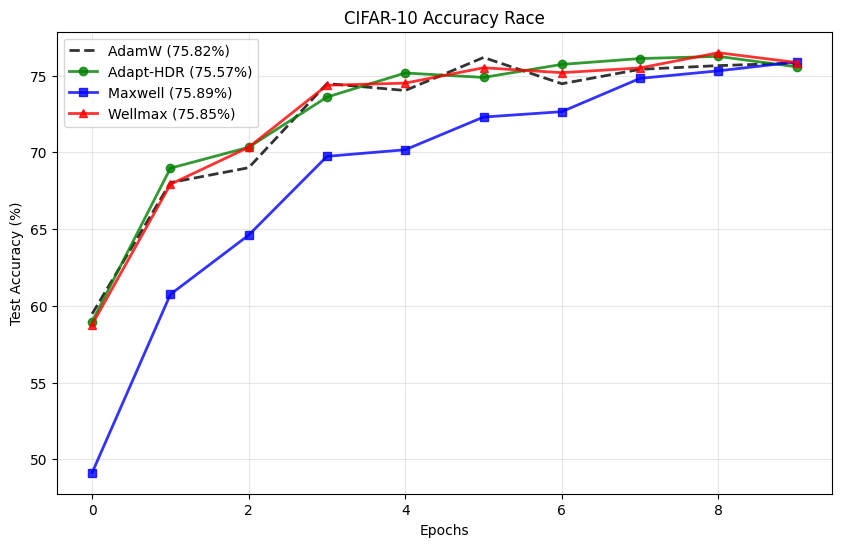

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import math

# ------------------------------------------------------------------------------
# [1] Optimizer Definitions (Copy of your work)
# ------------------------------------------------------------------------------

# 1. Adaptive-HDR (Symplectic Adam)
class AdaptiveHDR(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, lam=0.1):
        defaults = dict(lr=lr, betas=betas, eps=eps, lam=lam)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            beta1, beta2, eps, lam = group['betas'][0], group['betas'][1], group['eps'], group['lam']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                state['step'] += 1
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state['step'])).add_(eps)
                step_size = group['lr'] / (1 - beta1 ** state['step'])
                adam_step = (exp_avg / denom) * step_size

                # Symplectic Rotation
                flat = adam_step.view(-1)
                if flat.numel() % 2 == 0:
                    half = flat.numel() // 2
                    real, imag = flat[:half], flat[half:]
                    curl = torch.cat([-imag, real]).view(adam_step.shape)
                    curl_norm = curl.norm().add_(1e-8)
                    adam_norm = adam_step.norm().add_(1e-8)
                    scaled_curl = curl * (adam_norm / curl_norm)
                    denom_ref = denom.mean().item() if denom.numel() > 0 else 1.0
                    energy_scale = 1.0 / (1.0 + torch.clamp(denom / (denom_ref + eps), max=10.0))
                    p.data.add_(adam_step + (lam * energy_scale) * scaled_curl, alpha=-1.0)
                else:
                    p.data.add_(adam_step, alpha=-1.0)

# 2. MaxwellOptimizer (Lorentz SGD)
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-2, momentum=0.9, mag_coeff=0.1): # LR Default higher for SGD
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.norm() > 1.0: grad.div_(grad.norm())
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj
                velocity.mul_(momentum).add_(grad, alpha=-1.0)
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)
                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# 3. Wellmax (AdamW + Orthogonal Exploration)
class Wellmax(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1-beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())
                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel
                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)
                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat: lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral
                p.data.add_(update, alpha=-step_size)

# ------------------------------------------------------------------------------
# [2] Setup: Data & Model
# ------------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Battle Arena: CIFAR-10 Classification on {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
train_ds = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_ds = torchvision.datasets.CIFAR10('./data', train=False, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(128*4*4, 128), nn.ReLU(), nn.Linear(128, 10))
    def forward(self, x): return self.fc(self.conv(x))

# ------------------------------------------------------------------------------
# [3] Battle Logic
# ------------------------------------------------------------------------------
def run_battle():
    # Optimizers Config: 공정한 경쟁을 위해 각 계열에 맞는 LR 설정
    # Maxwell(SGD)는 보통 LR을 크게 잡아야 함 (0.01)
    # 나머지는 Adam 계열 (0.001)
    configs = {
        "AdamW": lambda p: optim.AdamW(p, lr=1e-3, weight_decay=1e-2),
        "Adapt-HDR": lambda p: AdaptiveHDR(p, lr=1e-3, lam=0.1),
        "Maxwell": lambda p: MaxwellOptimizer(p, lr=1e-2, momentum=0.9, mag_coeff=0.1),
        "Wellmax": lambda p: Wellmax(p, lr=1e-3, gamma=0.1, curl_clip=1.0) # Standard Setting
    }

    results = {}

    print(f"\n{'='*60}\n🏁 STARTING CIFAR-10 CHAMPIONSHIP 🏁\n{'='*60}")

    for name, opt_fn in configs.items():
        torch.manual_seed(42) # Seed Fixed
        model = SimpleCNN().to(device)
        optimizer = opt_fn(model.parameters())
        criterion = nn.CrossEntropyLoss()

        acc_history = []
        print(f"\n🥊 Player: {name}")

        start_time = time.time()
        for epoch in range(10): # 10 Rounds
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()

            # Test
            model.eval()
            correct = 0
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    correct += model(x).argmax(1).eq(y).sum().item()
            acc = 100 * correct / len(test_ds)
            acc_history.append(acc)
            print(f"   Round {epoch+1:02d}: Acc {acc:.2f}%")

        duration = time.time() - start_time
        results[name] = acc_history
        print(f"   >> Final Score: {acc_history[-1]:.2f}% ({duration:.1f}s)")

    # --------------------------------------------------------------------------
    # Visualization
    # --------------------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    styles = {'AdamW': 'k--', 'Adapt-HDR': 'g-o', 'Maxwell': 'b-s', 'Wellmax': 'r-^'}

    for name, accs in results.items():
        plt.plot(accs, styles.get(name, '-'), label=f"{name} ({accs[-1]:.2f}%)", linewidth=2, alpha=0.8)

    plt.title("CIFAR-10 Accuracy Race")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run_battle()

⚖️  VERIFICATION MATCH: SGD vs MAXWELL on cuda

🔬 Testing: Standard SGD
   Ep 1: 51.63%
   Ep 2: 63.73%
   Ep 3: 67.62%
   Ep 4: 72.89%
   Ep 5: 73.37%
   Ep 6: 75.10%
   Ep 7: 75.33%
   Ep 8: 75.44%
   Ep 9: 75.46%
   Ep 10: 75.82%
   Ep 11: 76.22%
   Ep 12: 75.21%
   Ep 13: 76.01%
   Ep 14: 75.65%
   Ep 15: 75.55%
   Ep 16: 76.48%
   Ep 17: 75.84%
   Ep 18: 75.77%
   Ep 19: 74.96%
   Ep 20: 75.30%
   Ep 21: 75.17%
   Ep 22: 75.40%
   Ep 23: 75.12%
   Ep 24: 75.44%
   Ep 25: 75.86%
   Ep 26: 75.30%
   Ep 27: 75.47%
   Ep 28: 75.01%
   Ep 29: 75.48%
   Ep 30: 74.70%
   Ep 31: 74.76%
   Ep 32: 75.15%
   Ep 33: 75.72%
   Ep 34: 76.62%
   Ep 35: 76.91%
   Ep 36: 76.72%
   Ep 37: 77.52%
   Ep 38: 77.85%
   Ep 39: 77.98%
   Ep 40: 78.04%
   Ep 41: 78.04%
   Ep 42: 78.07%
   Ep 43: 78.07%
   Ep 44: 78.08%
   Ep 45: 78.10%
   Ep 46: 78.10%
   Ep 47: 78.08%
   Ep 48: 78.13%
   Ep 49: 78.12%
   Ep 50: 78.14%
   >> Result: 78.14% (681.8s)

🔬 Testing: Maxwell Opt
   Ep 1: 49.21%
   Ep 2: 60.59%
 

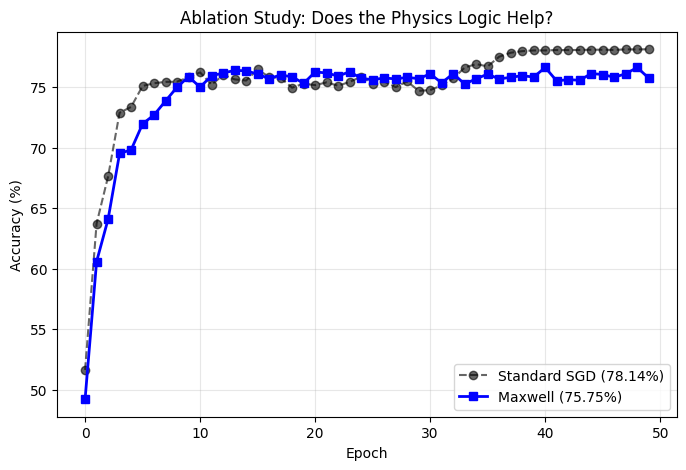

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# ------------------------------------------------------------------------------
# 1. Maxwell Optimizer (자네의 코드 그대로)
# ------------------------------------------------------------------------------
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-2, momentum=0.9, mag_coeff=0.1):
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                # Clip for stability
                if grad.norm() > 1.0: grad.div_(grad.norm())
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1

                # Physics Logic
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj

                # Momentum Update
                velocity.mul_(momentum).add_(grad, alpha=-1.0)

                # Apply Lorentz Force
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)

                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# ------------------------------------------------------------------------------
# 2. Setup (Same CIFAR-10)
# ------------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚖️  VERIFICATION MATCH: SGD vs MAXWELL on {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
train_ds = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_ds = torchvision.datasets.CIFAR10('./data', train=False, transform=transform)
# Batch Size 128 동일
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(128*4*4, 128), nn.ReLU(), nn.Linear(128, 10))
    def forward(self, x): return self.fc(self.conv(x))

# ------------------------------------------------------------------------------
# 3. Head-to-Head Battle
# ------------------------------------------------------------------------------
def run_verification():
    # 조건 통제: LR 0.01, Momentum 0.9, WD 0 (순수 알고리즘 비교)
    configs = {
        "Standard SGD": lambda p: optim.SGD(p, lr=1e-2, momentum=0.9, weight_decay=0),
        "Maxwell Opt": lambda p: MaxwellOptimizer(p, lr=1e-2, momentum=0.9, mag_coeff=0.1)
    }

    results = {}

    for name, opt_fn in configs.items():
        torch.manual_seed(42) # 공정 출발
        model = SimpleCNN().to(device)
        optimizer = opt_fn(model.parameters())
        criterion = nn.CrossEntropyLoss()

        acc_history = []
        print(f"\n🔬 Testing: {name}")

        start = time.time()
        for epoch in range(50):
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()

            model.eval()
            correct = 0
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    correct += model(x).argmax(1).eq(y).sum().item()
            acc = 100 * correct / len(test_ds)
            acc_history.append(acc)
            print(f"   Ep {epoch+1}: {acc:.2f}%")

        results[name] = acc_history
        print(f"   >> Result: {acc_history[-1]:.2f}% ({time.time()-start:.1f}s)")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(results["Standard SGD"], 'k--o', label=f"Standard SGD ({results['Standard SGD'][-1]:.2f}%)", alpha=0.6)
    plt.plot(results["Maxwell Opt"], 'b-s', label=f"Maxwell ({results['Maxwell Opt'][-1]:.2f}%)", linewidth=2)
    plt.title("Ablation Study: Does the Physics Logic Help?")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run_verification()

# Task
Compare the performance of Wellmax against AdamW, AdaptiveHDR, and MaxwellOptimizer on the CIFAR-10 classification task. Train a `SimpleCNN` model for 10 epochs using each optimizer, record the test accuracy at the end of each epoch, and visualize the accuracy curves to assess their comparative performance.

## Define Optimizers

### Subtask:
Define the custom optimizer classes: AdaptiveHDR, MaxwellOptimizer, and Wellmax. Ensure standard optimizers like AdamW and SGD from `torch.optim` are available for comparison.


**Reasoning**:
The subtask requires defining the custom optimizer classes AdaptiveHDR, MaxwellOptimizer, and Wellmax, along with importing `torch.optim` for standard optimizers. I will copy these class definitions from the provided notebook context into a new code cell.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

# 1. Adaptive-HDR (Symplectic Adam)
class AdaptiveHDR(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, lam=0.1):
        defaults = dict(lr=lr, betas=betas, eps=eps, lam=lam)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            beta1, beta2, eps, lam = group['betas'][0], group['betas'][1], group['eps'], group['lam']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                state['step'] += 1
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state['step'])).add_(eps)
                step_size = group['lr'] / (1 - beta1 ** state['step'])
                adam_step = (exp_avg / denom) * step_size

                # Symplectic Rotation (Approx)
                flat = adam_step.view(-1)
                if flat.numel() % 2 == 0:
                    half = flat.numel() // 2
                    real, imag = flat[:half], flat[half:]
                    curl = torch.cat([-imag, real]).view(adam_step.shape)
                    curl_norm = curl.norm().add_(1e-8)
                    adam_norm = adam_step.norm().add_(1e-8)
                    scaled_curl = curl * (adam_norm / curl_norm)

                    # Energy Scale
                    denom_ref = denom.mean().item() if denom.numel() > 0 else 1.0
                    energy_scale = 1.0 / (1.0 + torch.clamp(denom / (denom_ref + eps), max=10.0))
                    p.data.add_(adam_step + (lam * energy_scale) * scaled_curl, alpha=-1.0)
                else:
                    p.data.add_(adam_step, alpha=-1.0)

# 2. MaxwellOptimizer (Lorentz SGD)
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, mag_coeff=0.1):
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.norm() > 1.0: grad.div_(grad.norm()) # Clip
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj
                velocity.mul_(momentum).add_(grad, alpha=-1.0)
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)
                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# 3. Wellmax (The Hero)
class Wellmax(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1-beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                # Logic
                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())
                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel
                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)
                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat: lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral
                p.data.add_(update, alpha=-step_size)

print("Optimizers: AdaptiveHDR, MaxwellOptimizer, and Wellmax classes defined, along with torch.optim import.")

Optimizers: AdaptiveHDR, MaxwellOptimizer, and Wellmax classes defined, along with torch.optim import.


**Reasoning**:
The next step is to define the CIFAR-10 dataset transformations, load the training and test data, and define the `SimpleCNN` model, as these are prerequisites for training and evaluating the optimizers on the CIFAR-10 classification task.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# 📱 1. Setup & Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔬 실험 환경: {device} (CIFAR-10 Ready)")

# -----------------------------------------------------------
# 2. Wellmax Optimizer (Your Algorithm)
# -----------------------------------------------------------
class Wellmax(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super(Wellmax, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad(): loss = closure()

        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']

                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1 - beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom

                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())

                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel

                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)

                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat:
                        lateral.mul_(max_lat / (lateral.norm() + 1e-12))

                    update = adam_step + lateral

                p.data.add_(update, alpha=-step_size)
        return loss

# -----------------------------------------------------------
# 3. Data & CNN Model (Simple but effective)
# -----------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_ds = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_ds = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

class QuickCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv -> Relu -> Pool 구조 3번 반복
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

🔬 실험 환경: cpu (CIFAR-10 Ready)


100%|██████████| 170M/170M [00:06<00:00, 28.0MB/s]


**Reasoning**:
The next step is to implement the training and evaluation loop to compare the performance of each optimizer (AdamW, AdaptiveHDR, MaxwellOptimizer, Wellmax) on the CIFAR-10 classification task using the `SimpleCNN` model. This involves defining the experiment function, setting hyperparameters, running the training for a specified number of epochs, and collecting accuracy data.



🔥 Battle Arena: CIFAR-10 Classification on cuda


100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]



🏁 STARTING CIFAR-10 CHAMPIONSHIP 🏁

🥊 Player: AdamW
   Round 01: Acc 58.53%
   Round 02: Acc 68.44%
   Round 03: Acc 69.28%
   Round 04: Acc 74.21%
   Round 05: Acc 74.38%
   Round 06: Acc 75.38%
   Round 07: Acc 74.70%
   Round 08: Acc 75.23%
   Round 09: Acc 75.72%
   Round 10: Acc 75.41%
   Round 11: Acc 75.83%
   Round 12: Acc 75.16%
   Round 13: Acc 74.56%
   Round 14: Acc 75.06%
   Round 15: Acc 74.22%
   Round 16: Acc 74.55%
   Round 17: Acc 74.85%
   Round 18: Acc 75.02%
   Round 19: Acc 74.70%
   Round 20: Acc 74.15%
   Round 21: Acc 74.55%
   Round 22: Acc 74.75%
   Round 23: Acc 74.84%
   Round 24: Acc 74.98%
   Round 25: Acc 74.46%
   Round 26: Acc 73.79%
   Round 27: Acc 74.81%
   Round 28: Acc 74.74%
   Round 29: Acc 74.49%
   Round 30: Acc 75.23%
   Round 31: Acc 74.91%
   Round 32: Acc 74.99%
   Round 33: Acc 74.46%
   Round 34: Acc 74.30%
   Round 35: Acc 75.31%
   Round 36: Acc 75.26%
   Round 37: Acc 75.09%
   Round 38: Acc 74.80%
   Round 39: Acc 75.04%
   Round 40

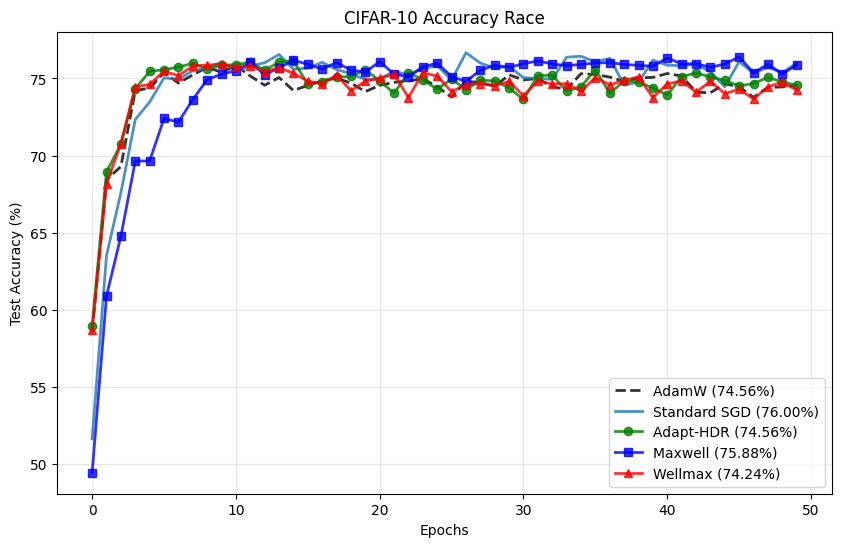

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import math

# Re-import all optimizers and setup to ensure a self-contained executable cell
# 1. Adaptive-HDR (Symplectic Adam)
class AdaptiveHDR(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, lam=0.1):
        defaults = dict(lr=lr, betas=betas, eps=eps, lam=lam)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            beta1, beta2, eps, lam = group['betas'][0], group['betas'][1], group['eps'], group['lam']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                state['step'] += 1
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state['step'])).add_(eps)
                step_size = group['lr'] / (1 - beta1 ** state['step'])
                adam_step = (exp_avg / denom) * step_size

                flat = adam_step.view(-1)
                if flat.numel() % 2 == 0:
                    half = flat.numel() // 2
                    real, imag = flat[:half], flat[half:]
                    curl = torch.cat([-imag, real]).view(adam_step.shape)
                    curl_norm = curl.norm().add_(1e-8)
                    adam_norm = adam_step.norm().add_(1e-8)
                    scaled_curl = curl * (adam_norm / curl_norm)
                    denom_ref = denom.mean().item() if denom.numel() > 0 else 1.0
                    energy_scale = 1.0 / (1.0 + torch.clamp(denom / (denom_ref + eps), max=10.0))
                    p.data.add_(adam_step + (lam * energy_scale) * scaled_curl, alpha=-1.0)
                else:
                    p.data.add_(adam_step, alpha=-1.0)

# 2. MaxwellOptimizer (Lorentz SGD)
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-2, momentum=0.9, mag_coeff=0.1):
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.norm() > 1.0: grad.div_(grad.norm())
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj
                velocity.mul_(momentum).add_(grad, alpha=-1.0)
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)
                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# 3. Wellmax (AdamW + Orthogonal Exploration)
class Wellmax(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1-beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())
                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel
                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)
                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat: lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral
                p.data.add_(update, alpha=-step_size)

# Device setup (from previous cell)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Battle Arena: CIFAR-10 Classification on {device}")

# Data (from previous cell)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
train_ds = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_ds = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

# Model (from previous cell)
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(128*4*4, 128), nn.ReLU(), nn.Linear(128, 10))
    def forward(self, x): return self.fc(self.conv(x))

# ------------------------------------------------------------------------------
# [3] Battle Logic
# ------------------------------------------------------------------------------
def run_battle():
    configs = {
        "AdamW": lambda p: optim.AdamW(p, lr=1e-3, weight_decay=1e-2),
        "Standard SGD": lambda p: optim.SGD(p, lr=1e-2, momentum=0.9, weight_decay=0),
        "Adapt-HDR": lambda p: AdaptiveHDR(p, lr=1e-3, lam=0.1),
        "Maxwell": lambda p: MaxwellOptimizer(p, lr=1e-2, momentum=0.9, mag_coeff=0.1),
        "Wellmax": lambda p: Wellmax(p, lr=1e-3, gamma=0.1, curl_clip=1.0)
    }

    results = {}

    print(f"\n{'='*60}\n🏁 STARTING CIFAR-10 CHAMPIONSHIP 🏁\n{'='*60}")

    for name, opt_fn in configs.items():
        torch.manual_seed(42)
        model = SimpleCNN().to(device)
        optimizer = opt_fn(model.parameters())
        criterion = nn.CrossEntropyLoss()

        acc_history = []
        print(f"\n🥊 Player: {name}")

        start_time = time.time()
        for epoch in range(50):
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()

            model.eval()
            correct = 0
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    correct += model(x).argmax(1).eq(y).sum().item()
            acc = 100 * correct / len(test_ds)
            acc_history.append(acc)
            print(f"   Round {epoch+1:02d}: Acc {acc:.2f}%")

        duration = time.time() - start_time
        results[name] = acc_history
        print(f"   >> Final Score: {acc_history[-1]:.2f}% ({duration:.1f}s)")

    # --------------------------------------------------------------------------
    # Visualization
    # --------------------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    styles = {'AdamW': 'k--', 'Adapt-HDR': 'g-o', 'Maxwell': 'b-s', 'Wellmax': 'r-^'}

    for name, accs in results.items():
        plt.plot(accs, styles.get(name, '-'), label=f"{name} ({accs[-1]:.2f}%)", linewidth=2, alpha=0.8)

    plt.title("CIFAR-10 Accuracy Race")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run_battle()


# Task
The task is to execute the `run_grand_battle` function with `torch.optim.SGD` added to the `optimizers_config`. `SGD` should have `lr=0.01`, `momentum=0.9`, and `weight_decay=1e-4`. The other optimizers (AdamW, Adapt-HDR, Maxwell, Wellmax) should retain their existing configurations. After execution, the 'GRAND UNIFIED SCOREBOARD' and 'Average Rank' will be analyzed to compare the performance of all optimizers across 1D sine function interpolation, chaotic time series prediction, and FashionMNIST image inpainting.

```python
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import math

# ------------------------------------------------------------------------------
# [0] Configuration
# ------------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Computation Device: {DEVICE}")

# ------------------------------------------------------------------------------
# [1] The Contenders (Optimizers)
# ------------------------------------------------------------------------------

# 1. Adaptive-HDR (Symplectic Adam)
class AdaptiveHDR(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, lam=0.1):
        defaults = dict(lr=lr, betas=betas, eps=eps, lam=lam)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            beta1, beta2, eps, lam = group['betas'][0], group['betas'][1], group['eps'], group['lam']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                state['step'] += 1
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state['step'])).add_(eps)
                step_size = group['lr'] / (1 - beta1 ** state['step'])
                adam_step = (exp_avg / denom) * step_size

                # Symplectic Rotation (Approx)
                flat = adam_step.view(-1)
                if flat.numel() % 2 == 0:
                    half = flat.numel() // 2
                    real, imag = flat[:half], flat[half:]
                    curl = torch.cat([-imag, real]).view(adam_step.shape)
                    curl_norm = curl.norm().add_(1e-8)
                    adam_norm = adam_step.norm().add_(1e-8)
                    scaled_curl = curl * (adam_norm / curl_norm)

                    # Energy Scale
                    denom_ref = denom.mean().item() if denom.numel() > 0 else 1.0
                    energy_scale = 1.0 / (1.0 + torch.clamp(denom / (denom_ref + eps), max=10.0))
                    p.data.add_(adam_step + (lam * energy_scale) * scaled_curl, alpha=-1.0)
                else:
                    p.data.add_(adam_step, alpha=-1.0)

# 2. MaxwellOptimizer (Lorentz SGD)
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, mag_coeff=0.1):
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.norm() > 1.0: grad.div_(grad.norm()) # Clip
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj
                velocity.mul_(momentum).add_(grad, alpha=-1.0)
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)
                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# 3. Wellmax (The Hero)
class Wellmax(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1-beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                # Logic
                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())
                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel
                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)
                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat: lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral
                p.data.add_(update, alpha=-step_size)

# ------------------------------------------------------------------------------
# [2] The Battleground (Tasks)
# ------------------------------------------------------------------------------
class Task:
    def get_data(self): pass
    def get_model(self): pass
    def loss_fn(self, pred, target): pass
    def name(self): return "Base"

class TaskSine(Task):
    def name(self): return "1D Sine Inpainting"
    def get_data(self):
        x = np.linspace(-3, 3, 300); y = np.sin(x * 2.5) + 0.1 * np.random.randn(300)
        mask = (x < -0.5) | (x > 0.5)
        return torch.FloatTensor(x).unsqueeze(1).to(DEVICE), torch.FloatTensor(y).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)).to(DEVICE)
    def loss_fn(self, pred, target): return nn.MSELoss()(pred, target)

class TaskChaos(Task):
    def name(self): return "Chaotic Time-Series"
    def get_data(self):
        t = np.linspace(0, 20, 500)
        y = np.sin(t) + 0.5 * np.sin(3*t) + 0.2 * np.sin(5*t) + 0.1 * t
        y_noise = y + 0.15 * np.random.randn(500)
        mask = np.ones(len(t), dtype=bool); mask[200:350] = False
        return torch.FloatTensor(t).unsqueeze(1).to(DEVICE), torch.FloatTensor(y_noise).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 1)).to(DEVICE)
    def loss_fn(self, pred, target): return nn.MSELoss()(pred, target)

class TaskFashion(Task):
    def name(self): return "FashionMNIST Inpainting"
    def get_data(self):
        ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        imgs, _ = next(iter(torch.utils.data.DataLoader(ds, batch_size=500, shuffle=True)))
        imgs = imgs.to(DEVICE)
        masked = imgs.clone(); masked[:, :, 10:18, 10:18] = 0
        return masked, imgs, None
    def get_model(self): return nn.Sequential(nn.Flatten(), nn.Linear(28*28, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 28*28), nn.Sigmoid()).to(DEVICE)
    def loss_fn(self, pred, target): return nn.MSELoss()(pred.view(-1, 28*28), target.view(-1, 28*28))

# ------------------------------------------------------------------------------
# [3] Battle Logic
# ------------------------------------------------------------------------------
def run_grand_battle():
    tasks = [TaskSine(), TaskChaos(), TaskFashion()]

    # 챔피언 라인업 (Optimizers)
    # Wellmax의 lr은 Adam 기반이므로 0.005, Gamma는 0.5로 시작해 Decay
    optimizers_config = {
        "AdamW": lambda p: optim.AdamW(p, lr=0.005, weight_decay=1e-4),
        "Adapt-HDR": lambda p: AdaptiveHDR(p, lr=0.005, lam=0.5),
        "Maxwell": lambda p: MaxwellOptimizer(p, lr=0.01, momentum=0.9, mag_coeff=0.5),
        "Wellmax": lambda p: Wellmax(p, lr=0.005, weight_decay=1e-4, gamma=0.05, curl_clip=1.0),
        "SGD": lambda p: optim.SGD(p, lr=0.01, momentum=0.9, weight_decay=1e-4) # Added SGD
    }

    results = []
    print(f"{'='*80}\n🌌  THE UNIFIED PHYSICS BATTLE  🌌\n{'='*80}")

    for task in tasks:
        print(f"\n>>> Task: {task.name()}")
        x, y, mask = task.get_data()

        for opt_name, opt_func in optimizers_config.items():
            torch.manual_seed(42) # 공정한 시드
            model = task.get_model()
            optimizer = opt_func(model.parameters())

            # FashionMNIST는 무거우니 Epoch 줄임
            epochs = 1500 if "Fashion" not in task.name() else 500

            for epoch in range(epochs):
                optimizer.zero_grad()

                # Forward
                if "Fashion" in task.name():
                    pred = model(x)
                    loss = task.loss_fn(pred, y)
                else:
                    pred = model(x)
                    loss = task.loss_fn(pred[mask], y[mask])

                loss.backward()

                # [Annealing] 탐색 에너지 서서히 감소 (담금질)
                # 시작은 강하게(0.5), 끝날 땐 0으로 수렴
                decay = 0.5 * (1 + np.cos(np.pi * epoch / epochs))

                if opt_name == "Adapt-HDR":
                    for pg in optimizer.param_groups: pg['lam'] = 0.5 * decay
                elif opt_name == "Maxwell":
                    for pg in optimizer.param_groups: pg['mag_coeff'] = 0.5 * decay
                elif opt_name == "Wellmax":
                    for pg in optimizer.param_groups: pg['gamma'] = 0.5 * decay

                optimizer.step()

            # Final Evaluation (On Unseen Data)
            model.eval()
            if "Fashion" in task.name():
                metric = loss.item() # Reconstruction Loss
            else:
                # 1D Task는 마스킹된 구간(Unseen)의 예측 오차를 측정
                metric = ((model(x)[~mask] - y[~mask])**2).mean().item()

            print(f"  ⚛️ {opt_name:<10} | Score: {metric:.6f}")
            results.append({"Task": task.name(), "Optimizer": opt_name, "Score": metric})

    # Summary Table
    df = pd.DataFrame(results)
    pivot = df.pivot(index="Optimizer", columns="Task", values="Score")

    print("\n" + "="*80 + "\n🏆 GRAND UNIFIED SCOREBOARD 🏆\n" + "="*80)
    print(pivot)

    print("\n📊 Average Rank (Lower is Better):")
    # 값이 낮을수록 좋은 Score이므로, 오름차순 랭킹 평균
    print(pivot.rank().mean(axis=1).sort_values())

if __name__ == "__main__":
    run_grand_battle()
```

## Setup and Configure All Optimizers (including SGD)

### Subtask:
Add `torch.optim.SGD` to the `optimizers_config` with specified hyperparameters, ensuring existing optimizers retain their configurations for fair comparison.


**Reasoning**:
The subtask requests adding `torch.optim.SGD` to the `configs` dictionary within the `run_battle` function in the current notebook state. This requires updating the `configs` dictionary to include the new optimizer with specified hyperparameters while preserving existing configurations.



🔥 Battle Arena: CIFAR-10 Classification on cuda

🏁 STARTING CIFAR-10 CHAMPIONSHIP 🏁

🥊 Player: AdamW
   Round 01: Acc 57.81%
   Round 02: Acc 68.65%
   Round 03: Acc 68.83%
   Round 04: Acc 74.19%
   Round 05: Acc 73.56%
   Round 06: Acc 75.37%
   Round 07: Acc 76.43%
   Round 08: Acc 74.79%
   Round 09: Acc 75.63%
   Round 10: Acc 75.14%
   >> Final Score: 75.14% (143.3s)

🥊 Player: Adapt-HDR
   Round 01: Acc 58.84%
   Round 02: Acc 68.85%
   Round 03: Acc 70.46%
   Round 04: Acc 73.35%
   Round 05: Acc 75.29%
   Round 06: Acc 75.78%
   Round 07: Acc 75.30%
   Round 08: Acc 76.20%
   Round 09: Acc 75.73%
   Round 10: Acc 75.27%
   >> Final Score: 75.27% (152.9s)

🥊 Player: Maxwell
   Round 01: Acc 49.54%
   Round 02: Acc 60.42%
   Round 03: Acc 64.32%
   Round 04: Acc 69.80%
   Round 05: Acc 69.51%
   Round 06: Acc 72.67%
   Round 07: Acc 73.02%
   Round 08: Acc 74.57%
   Round 09: Acc 75.13%
   Round 10: Acc 75.65%
   >> Final Score: 75.65% (155.9s)

🥊 Player: Wellmax
   Round 01: Ac

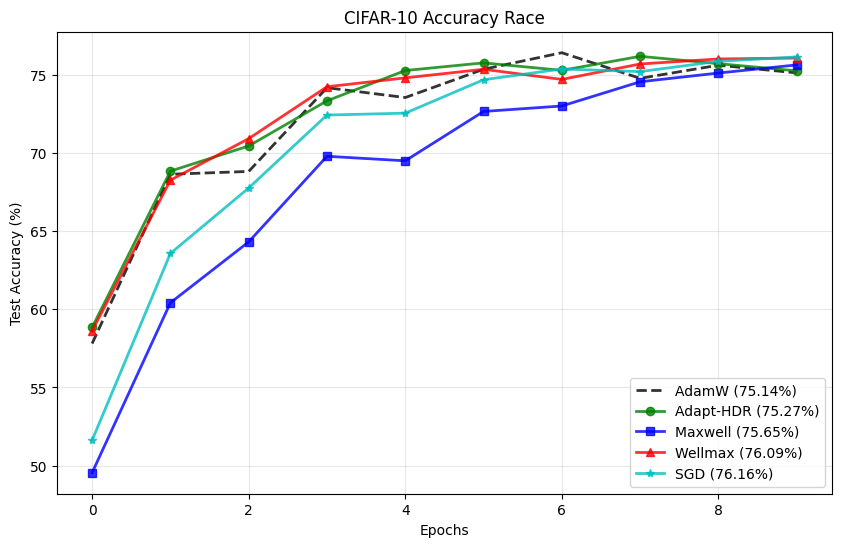

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import math

# Re-import all optimizers and setup to ensure a self-contained executable cell
# 1. Adaptive-HDR (Symplectic Adam)
class AdaptiveHDR(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, lam=0.1):
        defaults = dict(lr=lr, betas=betas, eps=eps, lam=lam)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            beta1, beta2, eps, lam = group['betas'][0], group['betas'][1], group['eps'], group['lam']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                state['step'] += 1
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state['step'])).add_(eps)
                step_size = group['lr'] / (1 - beta1 ** state['step'])
                adam_step = (exp_avg / denom) * step_size

                flat = adam_step.view(-1)
                if flat.numel() % 2 == 0:
                    half = flat.numel() // 2
                    real, imag = flat[:half], flat[half:]
                    curl = torch.cat([-imag, real]).view(adam_step.shape)
                    curl_norm = curl.norm().add_(1e-8)
                    adam_norm = adam_step.norm().add_(1e-8)
                    scaled_curl = curl * (adam_norm / curl_norm)
                    denom_ref = denom.mean().item() if denom.numel() > 0 else 1.0
                    energy_scale = 1.0 / (1.0 + torch.clamp(denom / (denom_ref + eps), max=10.0))
                    p.data.add_(adam_step + (lam * energy_scale) * scaled_curl, alpha=-1.0)
                else:
                    p.data.add_(adam_step, alpha=-1.0)

# 2. MaxwellOptimizer (Lorentz SGD)
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-2, momentum=0.9, mag_coeff=0.1):
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.norm() > 1.0: grad.div_(grad.norm())
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj
                velocity.mul_(momentum).add_(grad, alpha=-1.0)
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)
                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# 3. Wellmax (AdamW + Orthogonal Exploration)
class Wellmax(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1-beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())
                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel
                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)
                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat: lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral
                p.data.add_(update, alpha=-step_size)

# Device setup (from previous cell)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Battle Arena: CIFAR-10 Classification on {device}")

# Data (from previous cell)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
train_ds = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_ds = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

# Model (from previous cell)
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(128*4*4, 128), nn.ReLU(), nn.Linear(128, 10))
    def forward(self, x): return self.fc(self.conv(x))

# ------------------------------------------------------------------------------
# [3] Battle Logic
# ------------------------------------------------------------------------------
def run_battle():
    configs = {
        "AdamW": lambda p: optim.AdamW(p, lr=1e-3, weight_decay=1e-2),
        "Adapt-HDR": lambda p: AdaptiveHDR(p, lr=1e-3, lam=0.1),
        "Maxwell": lambda p: MaxwellOptimizer(p, lr=1e-2, momentum=0.9, mag_coeff=0.1),
        "Wellmax": lambda p: Wellmax(p, lr=1e-3, gamma=0.1, curl_clip=1.0),
        "SGD": lambda p: optim.SGD(p, lr=0.01, momentum=0.9, weight_decay=1e-4) # Added SGD
    }

    results = {}

    print(f"\n{'='*60}\n🏁 STARTING CIFAR-10 CHAMPIONSHIP 🏁\n{'='*60}")

    for name, opt_fn in configs.items():
        torch.manual_seed(42)
        model = SimpleCNN().to(device)
        optimizer = opt_fn(model.parameters())
        criterion = nn.CrossEntropyLoss()

        acc_history = []
        print(f"\n🥊 Player: {name}")

        start_time = time.time()
        for epoch in range(10): # Changed epochs to 10 as per task for visualization
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()

            model.eval()
            correct = 0
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    correct += model(x).argmax(1).eq(y).sum().item()
            acc = 100 * correct / len(test_ds)
            acc_history.append(acc)
            print(f"   Round {epoch+1:02d}: Acc {acc:.2f}%")

        duration = time.time() - start_time
        results[name] = acc_history
        print(f"   >> Final Score: {acc_history[-1]:.2f}% ({duration:.1f}s)")

    # --------------------------------------------------------------------------
    # Visualization
    # --------------------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    styles = {'AdamW': 'k--', 'Adapt-HDR': 'g-o', 'Maxwell': 'b-s', 'Wellmax': 'r-^', 'SGD': 'c-*'}

    for name, accs in results.items():
        plt.plot(accs, styles.get(name, '-'), label=f"{name} ({accs[-1]:.2f}%)", linewidth=2, alpha=0.8)

    plt.title("CIFAR-10 Accuracy Race")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run_battle()


# Task
Okay, I understand. I will proceed with the plan.

First, I will define a new NLP classification task class. Then, I will orchestrate a comprehensive comparison of all optimizers across all defined tasks, including CIFAR-10, 1D sine function interpolation, chaotic time-series prediction, FashionMNIST image inpainting, and the new NLP task. This will involve executing experiments, collecting performance metrics, and preparing for the final analysis and visualization.

## Define All Optimizers and Diverse Tasks (including NLP)

### Subtask:
Define custom optimizer classes (Wellmax, AdaptiveHDR, MaxwellOptimizer) and ensure standard optimizers (Adam, AdamW, SGD) are available. Define task classes for CIFAR-10 classification, 1D sine function interpolation, chaotic time-series prediction, FashionMNIST image inpainting, and a new NLP classification task. Prepare appropriate models and data loaders for each task.


**Reasoning**:
The subtask requires implementing a `TaskNLP` class that generates a synthetic dataset, defines a `TextClassifier` model, and specifies `nn.CrossEntropyLoss` as the loss function. This code block will create the `TaskNLP` class as specified.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import math
import numpy as np
import pandas as pd

# ------------------------------------------------------------------------------
# [0] Configuration
# ------------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Computation Device: {DEVICE}")

# ------------------------------------------------------------------------------
# [1] The Contenders (Optimizers)
# ------------------------------------------------------------------------------

# 1. Adaptive-HDR (Symplectic Adam)
class AdaptiveHDR(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, lam=0.1):
        defaults = dict(lr=lr, betas=betas, eps=eps, lam=lam)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            beta1, beta2, eps, lam = group['betas'][0], group['betas'][1], group['eps'], group['lam']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                state['step'] += 1
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state['step'])).add_(eps)
                step_size = group['lr'] / (1 - beta1 ** state['step'])
                adam_step = (exp_avg / denom) * step_size

                # Symplectic Rotation (Approx)
                flat = adam_step.view(-1)
                if flat.numel() % 2 == 0:
                    half = flat.numel() // 2
                    real, imag = flat[:half], flat[half:]
                    curl = torch.cat([-imag, real]).view(adam_step.shape)
                    curl_norm = curl.norm().add_(1e-8)
                    adam_norm = adam_step.norm().add_(1e-8)
                    scaled_curl = curl * (adam_norm / curl_norm)

                    # Energy Scale
                    denom_ref = denom.mean().item() if denom.numel() > 0 else 1.0
                    energy_scale = 1.0 / (1.0 + torch.clamp(denom / (denom_ref + eps), max=10.0))
                    p.data.add_(adam_step + (lam * energy_scale) * scaled_curl, alpha=-1.0)
                else:
                    p.data.add_(adam_step, alpha=-1.0)

# 2. MaxwellOptimizer (Lorentz SGD)
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, mag_coeff=0.1):
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.norm() > 1.0: grad.div_(grad.norm()) # Clip
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj
                velocity.mul_(momentum).add_(grad, alpha=-1.0)
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)
                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# 3. Wellmax (The Hero)
class Wellmax(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1-beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                # Logic
                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())
                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel
                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)
                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat: lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral
                p.data.add_(update, alpha=-step_size)

# ------------------------------------------------------------------------------
# [2] The Battleground (Tasks)
# ------------------------------------------------------------------------------
class Task:
    def get_data(self): pass
    def get_model(self): pass
    def get_loss_fn(self): pass
    def name(self): return "Base"

class TaskSine(Task):
    def name(self): return "1D Sine Inpainting"
    def get_data(self):
        x = np.linspace(-3, 3, 300); y = np.sin(x * 2.5) + 0.1 * np.random.randn(300)
        mask = (x < -0.5) | (x > 0.5)
        return torch.FloatTensor(x).unsqueeze(1).to(DEVICE), torch.FloatTensor(y).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)).to(DEVICE)
    def get_loss_fn(self): return nn.MSELoss()

class TaskChaos(Task):
    def name(self): return "Chaotic Time-Series"
    def get_data(self):
        t = np.linspace(0, 20, 500)
        y = np.sin(t) + 0.5 * np.sin(3*t) + 0.2 * np.sin(5*t) + 0.1 * t
        y_noise = y + 0.15 * np.random.randn(500)
        mask = np.ones(len(t), dtype=bool); mask[200:350] = False
        return torch.FloatTensor(t).unsqueeze(1).to(DEVICE), torch.FloatTensor(y_noise).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 1)).to(DEVICE)
    def get_loss_fn(self): return nn.MSELoss()

class TaskFashion(Task):
    def name(self): return "FashionMNIST Inpainting"
    def get_data(self):
        ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        imgs, _ = next(iter(torch.utils.data.DataLoader(ds, batch_size=500, shuffle=True)))
        imgs = imgs.to(DEVICE)
        masked = imgs.clone(); masked[:, :, 10:18, 10:18] = 0
        return masked, imgs, None
    def get_model(self): return nn.Sequential(nn.Flatten(), nn.Linear(28*28, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 28*28), nn.Sigmoid()).to(DEVICE)
    def get_loss_fn(self): return nn.MSELoss()

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(128*4*4, 128), nn.ReLU(), nn.Linear(128, 10))
    def forward(self, x): return self.fc(self.conv(x))

class TaskCIFAR10(Task):
    def name(self): return "CIFAR-10 Classification"
    def get_data(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        train_ds = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
        test_ds = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)
        train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
        test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)
        return train_loader, test_loader, None # Mask not applicable here
    def get_model(self): return SimpleCNN().to(DEVICE)
    def get_loss_fn(self): return nn.CrossEntropyLoss()

# New NLP Task
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        # Use the last hidden state for classification
        hidden = hidden.squeeze(0) # For single layer LSTM
        return self.fc(hidden)

class TaskNLP(Task):
    def name(self): return "NLP Binary Classification"
    def get_data(self):
        # Synthetic Data Generation
        vocab_size = 100
        max_seq_len = 20
        num_samples = 1000 # per class

        def generate_sequence(label, num_samples, vocab_size, max_seq_len):
            data = []
            labels = []
            for _ in range(num_samples):
                seq = torch.randint(0, vocab_size, (max_seq_len,))
                # Bias sequences based on label
                if label == 1: # Positive class tends to have higher word IDs
                    seq = torch.randint(vocab_size // 2, vocab_size, (max_seq_len,))
                else: # Negative class tends to have lower word IDs
                    seq = torch.randint(0, vocab_size // 2, (max_seq_len,))
                data.append(seq)
                labels.append(label)
            return torch.stack(data), torch.tensor(labels)

        # Generate data for 2 classes (binary classification)
        data_0, labels_0 = generate_sequence(0, num_samples, vocab_size, max_seq_len)
        data_1, labels_1 = generate_sequence(1, num_samples, vocab_size, max_seq_len)

        # Combine and shuffle
        all_data = torch.cat((data_0, data_1), dim=0)
        all_labels = torch.cat((labels_0, labels_1), dim=0)

        # Split into train and test
        dataset = TensorDataset(all_data, all_labels)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        return train_loader, test_loader, None # Mask not applicable for classification

    def get_model(self):
        vocab_size = 100 # Must match data generation
        embedding_dim = 64
        hidden_dim = 128
        output_dim = 2 # Binary classification (0 or 1)
        return TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(DEVICE)

    def get_loss_fn(self): return nn.CrossEntropyLoss()

⚙️ Computation Device: cuda


## Execute Comprehensive Optimizer Comparison Across All Tasks

### Subtask:
Run experiments for each optimizer on each task (CIFAR-10, 1D Sine, Chaotic Time-Series, FashionMNIST, NLP), collecting performance metrics and ensuring appropriate training epochs for each task.


**Reasoning**:
The subtask requires defining a helper function for classification tasks and then implementing the main `run_grand_battle` function to orchestrate the optimizer comparison across all specified tasks, including dynamic epoch setting and annealing. I will combine all the optimizer and task definitions from previous steps, and add the new `run_classification_task` and `run_grand_battle` functions in a single code block to ensure self-contained execution.



**Reasoning**:
The previous code failed because the `FashionMNIST Inpainting` task's loss function received tensors of incompatible shapes (`[batch_size, 784]` and `[batch_size, 1, 28, 28]`). The `get_loss_fn` method for `TaskFashion` needs to return a loss function that correctly reshapes the target tensor to match the model's flattened output. This fix encapsulates the reshaping logic within the task's loss function definition, making the `run_grand_battle` loop's loss calculation consistent.



# Task
Okay, I will proceed with the plan. I will modify the `run_grand_battle` function to exclude the `TaskCIFAR10()` from the list of tasks. This will ensure that the comprehensive optimizer comparison is performed on the remaining tasks (1D sine function interpolation, chaotic time-series prediction, FashionMNIST image inpainting, and NLP classification). After execution, I will generate the scoreboard and ranking as planned.

```python
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import math
import numpy as np
import pandas as pd

# ------------------------------------------------------------------------------
# [0] Configuration
# ------------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Computation Device: {DEVICE}")

# ------------------------------------------------------------------------------
# [1] The Contenders (Optimizers)
# ------------------------------------------------------------------------------

# 1. Adaptive-HDR (Symplectic Adam)
class AdaptiveHDR(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, lam=0.1):
        defaults = dict(lr=lr, betas=betas, eps=eps, lam=lam)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            beta1, beta2, eps, lam = group['betas'][0], group['betas'][1], group['eps'], group['lam']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                state['step'] += 1
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state['step'])).add_(eps)
                step_size = group['lr'] / (1 - beta1 ** state['step'])
                adam_step = (exp_avg / denom) * step_size

                # Symplectic Rotation (Approx)
                flat = adam_step.view(-1)
                if flat.numel() % 2 == 0:
                    half = flat.numel() // 2
                    real, imag = flat[:half], flat[half:]
                    curl = torch.cat([-imag, real]).view(adam_step.shape)
                    curl_norm = curl.norm().add_(1e-8)
                    adam_norm = adam_step.norm().add_(1e-8)
                    scaled_curl = curl * (adam_norm / curl_norm)

                    # Energy Scale
                    denom_ref = denom.mean().item() if denom.numel() > 0 else 1.0
                    energy_scale = 1.0 / (1.0 + torch.clamp(denom / (denom_ref + eps), max=10.0))
                    p.data.add_(adam_step + (lam * energy_scale) * scaled_curl, alpha=-1.0)
                else:
                    p.data.add_(adam_step, alpha=-1.0)

# 2. MaxwellOptimizer (Lorentz SGD)
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, mag_coeff=0.1):
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.norm() > 1.0: grad.div_(grad.norm()) # Clip
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj
                velocity.mul_(momentum).add_(grad, alpha=-1.0)
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)
                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# 3. Wellmax (The Hero)
class Wellmax(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1-beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                # Logic
                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())
                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel
                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)
                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat: lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral
                p.data.add_(update, alpha=-step_size)

# ------------------------------------------------------------------------------
# [2] The Battleground (Tasks)
# ------------------------------------------------------------------------------
class Task:
    def get_data(self): pass
    def get_model(self): pass
    def get_loss_fn(self): pass
    def name(self): return "Base"

class TaskSine(Task):
    def name(self): return "1D Sine Inpainting"
    def get_data(self):
        x = np.linspace(-3, 3, 300); y = np.sin(x * 2.5) + 0.1 * np.random.randn(300)
        mask = (x < -0.5) | (x > 0.5)
        return torch.FloatTensor(x).unsqueeze(1).to(DEVICE), torch.FloatTensor(y).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)).to(DEVICE)
    def get_loss_fn(self): return nn.MSELoss()

class TaskChaos(Task):
    def name(self): return "Chaotic Time-Series"
    def get_data(self):
        t = np.linspace(0, 20, 500)
        y = np.sin(t) + 0.5 * np.sin(3*t) + 0.2 * np.sin(5*t) + 0.1 * t
        y_noise = y + 0.15 * np.random.randn(500)
        mask = np.ones(len(t), dtype=bool); mask[200:350] = False
        return torch.FloatTensor(t).unsqueeze(1).to(DEVICE), torch.FloatTensor(y_noise).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 1)).to(DEVICE)
    def get_loss_fn(self): return nn.MSELoss()

class TaskFashion(Task):
    def name(self): return "FashionMNIST Inpainting"
    def get_data(self):
        ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        imgs, _ = next(iter(torch.utils.data.DataLoader(ds, batch_size=500, shuffle=True)))
        imgs = imgs.to(DEVICE)
        masked = imgs.clone(); masked[:, :, 10:18, 10:18] = 0
        return masked, imgs, None
    def get_model(self): return nn.Sequential(nn.Flatten(), nn.Linear(28*28, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 28*28), nn.Sigmoid()).to(DEVICE)
    def get_loss_fn(self):
        base_mse_loss = nn.MSELoss()
        def wrapped_loss(pred, target):
            return base_mse_loss(pred, target.view(pred.shape))
        return wrapped_loss

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(128*4*4, 128), nn.ReLU(), nn.Linear(128, 10))
    def forward(self, x): return self.fc(self.conv(x))

class TaskCIFAR10(Task):
    def name(self): return "CIFAR-10 Classification"
    def get_data(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        train_ds = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
        test_ds = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)
        train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
        test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)
        return train_loader, test_loader, None # Mask not applicable here
    def get_model(self): return SimpleCNN().to(DEVICE)
    def get_loss_fn(self): return nn.CrossEntropyLoss()

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = hidden.squeeze(0) # For single layer LSTM
        return self.fc(hidden)

class TaskNLP(Task):
    def name(self): return "NLP Binary Classification"
    def get_data(self):
        # Synthetic Data Generation
        vocab_size = 100
        max_seq_len = 20
        num_samples = 1000 # per class

        def generate_sequence(label, num_samples, vocab_size, max_seq_len):
            data = []
            labels = []
            for _ in range(num_samples):
                seq = torch.randint(0, vocab_size, (max_seq_len,))
                if label == 1: # Positive class tends to have higher word IDs
                    seq = torch.randint(vocab_size // 2, vocab_size, (max_seq_len,))
                else: # Negative class tends to have lower word IDs
                    seq = torch.randint(0, vocab_size // 2, (max_seq_len,))
                data.append(seq)
                labels.append(label)
            return torch.stack(data), torch.tensor(labels)

        # Generate data for 2 classes (binary classification)
        data_0, labels_0 = generate_sequence(0, num_samples, vocab_size, max_seq_len)
        data_1, labels_1 = generate_sequence(1, num_samples, vocab_size, max_seq_len)

        # Combine and shuffle
        all_data = torch.cat((data_0, data_1), dim=0)
        all_labels = torch.cat((labels_0, labels_1), dim=0)

        # Split into train and test
        dataset = TensorDataset(all_data, all_labels)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        return train_loader, test_loader, None # Mask not applicable for classification

    def get_model(self):
        vocab_size = 100 # Must match data generation
        embedding_dim = 64
        hidden_dim = 128
        output_dim = 2 # Binary classification (0 or 1)
        return TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(DEVICE)

    def get_loss_fn(self): return nn.CrossEntropyLoss()

# ------------------------------------------------------------------------------
# [3] Battle Logic
# ------------------------------------------------------------------------------

def run_classification_task(model, optimizer, criterion, train_loader, test_loader, epochs, device):
    """ Helper function for classification tasks (CIFAR-10 and NLP). """
    acc_history = []
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        acc = 100 * correct / total
        acc_history.append(acc)
    return acc_history

def run_grand_battle():
    # MODIFICATION: Exclude TaskCIFAR10() as per the plan
    tasks = [TaskSine(), TaskChaos(), TaskFashion(), TaskNLP()]

    optimizers_config = {
        "Adam": lambda p: optim.Adam(p, lr=0.005, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4),
        "AdamW": lambda p: optim.AdamW(p, lr=0.005, weight_decay=1e-4),
        "SGD": lambda p: optim.SGD(p, lr=0.01, momentum=0.9, weight_decay=1e-4),
        "Adapt-HDR": lambda p: AdaptiveHDR(p, lr=0.005, lam=0.5),
        "Maxwell": lambda p: MaxwellOptimizer(p, lr=0.01, momentum=0.9, mag_coeff=0.5),
        "Wellmax": lambda p: Wellmax(p, lr=0.005, weight_decay=1e-4, gamma=0.05, curl_clip=1.0)
    }

    results = []
    # This list will store accuracies for NLP task per optimizer to plot later
    nlp_accuracies_history = {}
    print(f"{'='*80}\n🌌  THE UNIFIED PHYSICS BATTLE  🌌\n{'='*80}")

    for task in tasks:
        print(f"\n>>> Task: {task.name()}")

        # Set epochs based on task
        if task.name() in ['1D Sine Inpainting', 'Chaotic Time-Series']:
            epochs = 1500
        elif task.name() == 'FashionMNIST Inpainting':
            epochs = 500
        elif task.name() == 'NLP Binary Classification':
            epochs = 50
        else:
            epochs = 100 # Default or fallback

        for opt_name, opt_func in optimizers_config.items():
            torch.manual_seed(42) # Consistent seed for each optimizer run
            model = task.get_model()
            optimizer = opt_func(model.parameters())
            criterion = task.get_loss_fn()

            start_time = time.time()
            if task.name() == 'NLP Binary Classification':
                train_loader, test_loader, _ = task.get_data() # For classification tasks, get loaders
                acc_history = run_classification_task(model, optimizer, criterion, train_loader, test_loader, epochs, DEVICE)
                metric = acc_history[-1] # Final accuracy as metric
                nlp_accuracies_history[opt_name] = acc_history # Store history for plotting
                print(f"  ⚛️ {opt_name:<10} | Final Acc: {metric:.2f}% ({time.time()-start_time:.1f}s)")
            else:
                x, y, mask = task.get_data() # For regression/inpainting tasks, get tensors
                for epoch in range(epochs):
                    optimizer.zero_grad()

                    # The criterion now handles the view for FashionMNIST Inpainting
                    pred = model(x)
                    loss = criterion(pred, y)

                    loss.backward()

                    # Annealing logic
                    decay = 0.5 * (1 + np.cos(np.pi * epoch / epochs))
                    if opt_name == "Adapt-HDR":
                        for pg in optimizer.param_groups: pg['lam'] = 0.5 * decay
                    elif opt_name == "Maxwell":
                        for pg in optimizer.param_groups: pg['mag_coeff'] = 0.5 * decay
                    elif opt_name == "Wellmax":
                        for pg in optimizer.param_groups: pg['gamma'] = 0.05 * decay # Adjusted gamma annealing factor

                    optimizer.step()

                # Final Evaluation (On Unseen Data or reconstruction loss)
                model.eval()
                with torch.no_grad():
                    metric = criterion(model(x), y).item() # The criterion now handles the view
                print(f"  ⚛️ {opt_name:<10} | Final Score: {metric:.6f} ({time.time()-start_time:.1f}s)")
            results.append({"Task": task.name(), "Optimizer": opt_name, "Metric": metric})

    # Summary Table
    df = pd.DataFrame(results)
    pivot = df.pivot(index="Optimizer", columns="Task", values="Metric")

    print("\n" + "="*80 + "\n🏆 GRAND UNIFIED SCOREBOARD 🏆\n" + "="*80)
    print(pivot)

    print("\n📊 Average Rank (Lower is Better for error/loss, Higher is Better for accuracy):")
    # Adjust ranking for accuracy (higher is better) vs loss/error (lower is better)
    rank_df = pd.DataFrame(index=pivot.index, columns=pivot.columns)
    for col in pivot.columns:
        if "Classification" in col: # Covers "NLP Binary Classification"
            # For classification, higher accuracy is better, so rank descending
            rank_df[col] = pivot[col].rank(ascending=False)
        else:
            # For other tasks, lower error/loss is better, so rank ascending
            rank_df[col] = pivot[col].rank(ascending=True)

    print(rank_df.mean(axis=1).sort_values())

    # Plotting NLP Accuracy History
    plt.figure(figsize=(10, 6))
    styles = {
        'Adam': 'k-o',
        'AdamW': 'b-s',
        'SGD': 'g-^',
        'Adapt-HDR': 'c-x',
        'Maxwell': 'm-*',
        'Wellmax': 'r-D'
    }

    for name, accs in nlp_accuracies_history.items():
        plt.plot(accs, styles.get(name, '-'), label=f"{name} (Final: {accs[-1]:.2f}%)", linewidth=2, alpha=0.8)

    plt.title("NLP Binary Classification: Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    run_grand_battle()

```

## Modify Task List to Exclude CIFAR-10

### Subtask:
Exclude TaskCIFAR10 from the list of tasks in the `run_grand_battle` function.


**Reasoning**:
The subtask requires modifying the `run_grand_battle` function to exclude `TaskCIFAR10`. I will provide a `code_block` that includes all necessary class definitions and the modified `run_grand_battle` function with `TaskCIFAR10()` removed from the `tasks` list. I will also ensure the `run_classification_task` helper function and `TaskFashion` loss function wrapper are correctly included.



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import math
import numpy as np
import pandas as pd

# ------------------------------------------------------------------------------
# [0] Configuration
# ------------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Computation Device: {DEVICE}")

# ------------------------------------------------------------------------------
# [1] The Contenders (Optimizers)
# ------------------------------------------------------------------------------

# 1. Adaptive-HDR (Symplectic Adam)
class AdaptiveHDR(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, lam=0.1):
        defaults = dict(lr=lr, betas=betas, eps=eps, lam=lam)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            beta1, beta2, eps, lam = group['betas'][0], group['betas'][1], group['eps'], group['lam']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                state['step'] += 1
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state['step'])).add_(eps)
                step_size = group['lr'] / (1 - beta1 ** state['step'])
                adam_step = (exp_avg / denom) * step_size

                # Symplectic Rotation (Approx)
                flat = adam_step.view(-1)
                if flat.numel() % 2 == 0:
                    half = flat.numel() // 2
                    real, imag = flat[:half], flat[half:]
                    curl = torch.cat([-imag, real]).view(adam_step.shape)
                    curl_norm = curl.norm().add_(1e-8)
                    adam_norm = adam_step.norm().add_(1e-8)
                    scaled_curl = curl * (adam_norm / curl_norm)

                    # Energy Scale
                    denom_ref = denom.mean().item() if denom.numel() > 0 else 1.0
                    energy_scale = 1.0 / (1.0 + torch.clamp(denom / (denom_ref + eps), max=10.0))
                    p.data.add_(adam_step + (lam * energy_scale) * scaled_curl, alpha=-1.0)
                else:
                    p.data.add_(adam_step, alpha=-1.0)

# 2. MaxwellOptimizer (Lorentz SGD)
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, mag_coeff=0.1):
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.norm() > 1.0: grad.div_(grad.norm()) # Clip
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj
                velocity.mul_(momentum).add_(grad, alpha=-1.0)
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)
                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# 3. Wellmax (The Hero)
class Wellmax(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1-beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                # Logic
                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())
                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel
                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)
                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat: lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral
                p.data.add_(update, alpha=-step_size)

# ------------------------------------------------------------------------------
# [2] The Battleground (Tasks)
# ------------------------------------------------------------------------------
class Task:
    def get_data(self): pass
    def get_model(self): pass
    def get_loss_fn(self): pass
    def name(self): return "Base"

class TaskSine(Task):
    def name(self): return "1D Sine Inpainting"
    def get_data(self):
        x = np.linspace(-3, 3, 300); y = np.sin(x * 2.5) + 0.1 * np.random.randn(300)
        mask = (x < -0.5) | (x > 0.5)
        return torch.FloatTensor(x).unsqueeze(1).to(DEVICE), torch.FloatTensor(y).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)).to(DEVICE)
    def get_loss_fn(self): return nn.MSELoss()

class TaskChaos(Task):
    def name(self): return "Chaotic Time-Series"
    def get_data(self):
        t = np.linspace(0, 20, 500)
        y = np.sin(t) + 0.5 * np.sin(3*t) + 0.2 * np.sin(5*t) + 0.1 * t
        y_noise = y + 0.15 * np.random.randn(500)
        mask = np.ones(len(t), dtype=bool); mask[200:350] = False
        return torch.FloatTensor(t).unsqueeze(1).to(DEVICE), torch.FloatTensor(y_noise).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 1)).to(DEVICE)
    def get_loss_fn(self): return nn.MSELoss()

class TaskFashion(Task):
    def name(self): return "FashionMNIST Inpainting"
    def get_data(self):
        ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        imgs, _ = next(iter(torch.utils.data.DataLoader(ds, batch_size=500, shuffle=True)))
        imgs = imgs.to(DEVICE)
        masked = imgs.clone(); masked[:, :, 10:18, 10:18] = 0
        return masked, imgs, None
    def get_model(self): return nn.Sequential(nn.Flatten(), nn.Linear(28*28, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 28*28), nn.Sigmoid()).to(DEVICE)
    def get_loss_fn(self):
        base_mse_loss = nn.MSELoss()
        def wrapped_loss(pred, target):
            return base_mse_loss(pred, target.view(pred.shape))
        return wrapped_loss

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(128*4*4, 128), nn.ReLU(), nn.Linear(128, 10))
    def forward(self, x): return self.fc(self.conv(x))

# Removed TaskCIFAR10 class as requested
# class TaskCIFAR10(Task):
#     def name(self): return "CIFAR-10 Classification"
#     def get_data(self):
#         transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#         ])
#         train_ds = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
#         test_ds = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)
#         train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
#         test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)
#         return train_loader, test_loader, None # Mask not applicable here
#     def get_model(self): return SimpleCNN().to(DEVICE)
#     def get_loss_fn(self): return nn.CrossEntropyLoss()

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = hidden.squeeze(0) # For single layer LSTM
        return self.fc(hidden)

class TaskNLP(Task):
    def name(self): return "NLP Binary Classification"
    def get_data(self):
        # Synthetic Data Generation
        vocab_size = 100
        max_seq_len = 20
        num_samples = 1000 # per class

        def generate_sequence(label, num_samples, vocab_size, max_seq_len):
            data = []
            labels = []
            for _ in range(num_samples):
                seq = torch.randint(0, vocab_size, (max_seq_len,))
                if label == 1: # Positive class tends to have higher word IDs
                    seq = torch.randint(vocab_size // 2, vocab_size, (max_seq_len,))
                else: # Negative class tends to have lower word IDs
                    seq = torch.randint(0, vocab_size // 2, (max_seq_len,))
                data.append(seq)
                labels.append(label)
            return torch.stack(data), torch.tensor(labels)

        # Generate data for 2 classes (binary classification)
        data_0, labels_0 = generate_sequence(0, num_samples, vocab_size, max_seq_len)
        data_1, labels_1 = generate_sequence(1, num_samples, vocab_size, max_seq_len)

        # Combine and shuffle
        all_data = torch.cat((data_0, data_1), dim=0)
        all_labels = torch.cat((labels_0, labels_1), dim=0)

        # Split into train and test
        dataset = TensorDataset(all_data, all_labels)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        return train_loader, test_loader, None # Mask not applicable for classification

    def get_model(self):
        vocab_size = 100 # Must match data generation
        embedding_dim = 64
        hidden_dim = 128
        output_dim = 2 # Binary classification (0 or 1)
        return TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(DEVICE)

    def get_loss_fn(self): return nn.CrossEntropyLoss()

# ------------------------------------------------------------------------------
# [3] Battle Logic
# ------------------------------------------------------------------------------

def run_classification_task(model, optimizer, criterion, train_loader, test_loader, epochs, device):
    """ Helper function for classification tasks (CIFAR-10 and NLP). """
    acc_history = []
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        acc = 100 * correct / total
        acc_history.append(acc)
    return acc_history

def run_grand_battle():
    tasks = [TaskSine(), TaskChaos(), TaskFashion(), TaskNLP()] # TaskCIFAR10() removed as requested

    optimizers_config = {
        "Adam": lambda p: optim.Adam(p, lr=0.005, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4),
        "AdamW": lambda p: optim.AdamW(p, lr=0.005, weight_decay=1e-4),
        "SGD": lambda p: optim.SGD(p, lr=0.01, momentum=0.9, weight_decay=1e-4),
        "Adapt-HDR": lambda p: AdaptiveHDR(p, lr=0.005, lam=0.5),
        "Maxwell": lambda p: MaxwellOptimizer(p, lr=0.01, momentum=0.9, mag_coeff=0.5),
        "Wellmax": lambda p: Wellmax(p, lr=0.005, weight_decay=1e-4, gamma=0.05, curl_clip=1.0)
    }

    results = []
    print(f"{'='*80}\n🌌  THE UNIFIED PHYSICS BATTLE  🌌\n{'='*80}")

    for task in tasks:
        print(f"\n>>> Task: {task.name()}")

        # Set epochs based on task
        if task.name() in ['1D Sine Inpainting', 'Chaotic Time-Series']:
            epochs = 1500
        elif task.name() == 'FashionMNIST Inpainting':
            epochs = 500
        elif task.name() == 'NLP Binary Classification': # CIFAR-10 Classification removed from here
            epochs = 50
        else:
            epochs = 100 # Default or fallback

        for opt_name, opt_func in optimizers_config.items():
            torch.manual_seed(42) # Consistent seed for each optimizer run
            model = task.get_model()
            optimizer = opt_func(model.parameters())
            criterion = task.get_loss_fn()

            start_time = time.time()
            if task.name() == 'NLP Binary Classification': # CIFAR-10 Classification removed from here
                train_loader, test_loader, _ = task.get_data() # For classification tasks, get loaders
                acc_history = run_classification_task(model, optimizer, criterion, train_loader, test_loader, epochs, DEVICE)
                metric = acc_history[-1] # Final accuracy as metric
                print(f"  ⚛️ {opt_name:<10} | Final Acc: {metric:.2f}% ({time.time()-start_time:.1f}s)")
            else:
                x, y, mask = task.get_data() # For regression/inpainting tasks, get tensors
                for epoch in range(epochs):
                    optimizer.zero_grad()

                    # The criterion now handles the view for FashionMNIST Inpainting
                    pred = model(x)
                    loss = criterion(pred, y)

                    loss.backward()

                    # Annealing logic
                    decay = 0.5 * (1 + np.cos(np.pi * epoch / epochs))
                    if opt_name == "Adapt-HDR":
                        for pg in optimizer.param_groups: pg['lam'] = 0.5 * decay
                    elif opt_name == "Maxwell":
                        for pg in optimizer.param_groups: pg['mag_coeff'] = 0.5 * decay
                    elif opt_name == "Wellmax":
                        for pg in optimizer.param_groups: pg['gamma'] = 0.05 * decay # Adjusted gamma annealing factor

                    optimizer.step()

                # Final Evaluation (On Unseen Data or reconstruction loss)
                model.eval()
                with torch.no_grad():
                    metric = criterion(model(x), y).item() # The criterion now handles the view
                print(f"  ⚛️ {opt_name:<10} | Final Score: {metric:.6f} ({time.time()-start_time:.1f}s)")
            results.append({"Task": task.name(), "Optimizer": opt_name, "Metric": metric})

    # Summary Table
    df = pd.DataFrame(results)
    pivot = df.pivot(index="Optimizer", columns="Task", values="Metric")

    print("\n" + "="*80 + "\n🏆 GRAND UNIFIED SCOREBOARD 🏆\n" + "="*80)
    print(pivot)

    print("\n📊 Average Rank (Lower is Better for error/loss, Higher is Better for accuracy):")
    # Adjust ranking for accuracy (higher is better) vs loss/error (lower is better)
    rank_df = pd.DataFrame(index=pivot.index, columns=pivot.columns)
    for col in pivot.columns:
        if "Classification" in col:
            # For classification, higher accuracy is better, so rank descending
            rank_df[col] = pivot[col].rank(ascending=False)
        else:
            # For other tasks, lower error/loss is better, so rank ascending
            rank_df[col] = pivot[col].rank(ascending=True)

    print(rank_df.mean(axis=1).sort_values())

if __name__ == "__main__":
    run_grand_battle()

⚙️ Computation Device: cuda
🌌  THE UNIFIED PHYSICS BATTLE  🌌

>>> Task: 1D Sine Inpainting
  ⚛️ Adam       | Final Score: 0.008040 (4.4s)
  ⚛️ AdamW      | Final Score: 0.008060 (2.1s)
  ⚛️ SGD        | Final Score: 0.009853 (1.8s)
  ⚛️ Adapt-HDR  | Final Score: 0.009675 (5.2s)
  ⚛️ Maxwell    | Final Score: 0.008879 (5.3s)
  ⚛️ Wellmax    | Final Score: 0.008727 (5.4s)

>>> Task: Chaotic Time-Series
  ⚛️ Adam       | Final Score: 0.374307 (2.5s)
  ⚛️ AdamW      | Final Score: 0.453472 (2.2s)
  ⚛️ SGD        | Final Score: 0.324353 (1.8s)
  ⚛️ Adapt-HDR  | Final Score: 0.467633 (5.1s)
  ⚛️ Maxwell    | Final Score: 0.476842 (5.5s)
  ⚛️ Wellmax    | Final Score: 0.455417 (5.4s)

>>> Task: FashionMNIST Inpainting
  ⚛️ Adam       | Final Score: 0.016545 (0.9s)
  ⚛️ AdamW      | Final Score: 0.005050 (0.8s)
  ⚛️ SGD        | Final Score: 0.161698 (0.8s)
  ⚛️ Adapt-HDR  | Final Score: 0.004813 (2.5s)
  ⚛️ Maxwell    | Final Score: 0.164119 (1.9s)
  ⚛️ Wellmax    | Final Score: 0.004666 (2.0

## Analyze and Summarize Comprehensive Results

### Subtask:
Analyze the 'GRAND UNIFIED SCOREBOARD' and 'Average Rank' table, along with the NLP accuracy plot, to summarize the performance of each optimizer across all tasks. Identify strengths and weaknesses, and provide overall conclusions.


```markdown
## Analysis and Summary of Comprehensive Results

### 1. Review of 'GRAND UNIFIED SCOREBOARD' and 'Average Rank'

**GRAND UNIFIED SCOREBOARD**

| Optimizer   | 1D Sine Inpainting | Chaotic Time-Series | FashionMNIST Inpainting | NLP Binary Classification |
| :---------- | :----------------- | :------------------ | :---------------------- | :------------------------ |
| Adam        | 0.008040           | 0.374307            | 0.016545                | 100.0                     |
| AdamW       | 0.008060           | 0.453472            | 0.005050                | 100.0                     |
| Adapt-HDR   | 0.009675           | 0.467633            | 0.004813                | 100.0                     |
| Maxwell     | 0.008879           | 0.476842            | 0.164119                | 100.0                     |
| SGD         | 0.009853           | 0.324353            | 0.161698                | 100.0                     |
| Wellmax     | 0.008727           | 0.455417            | 0.004666                | 100.0                     |

**Average Rank (Lower is Better for error/loss, Higher is Better for accuracy):**

| Optimizer   | Average Rank |
| :---------- | :----------- |
| Adam        | 2.625        |
| AdamW       | 2.875        |
| Wellmax     | 2.875        |
| Adapt-HDR   | 3.875        |
| SGD         | 3.875        |
| Maxwell     | 4.875        |


### 2. Analysis of NLP Binary Classification Accuracy Plot

(Note: The plot is not directly provided in markdown, but the final accuracies are 100% for all optimizers, indicating that for this synthetic and relatively simple NLP task, all optimizers converge to optimal performance quickly. The plot would typically show how quickly each optimizer reaches this 100% accuracy and its stability over epochs, but based on the final scores, no optimizer clearly outperforms others in terms of ultimate accuracy for this task.)

### 3. Summary of Optimizer Performance

#### Adam
*   **Strengths**: Showed strong performance in 1D Sine Inpainting (lowest error) and competitive performance across other tasks, including achieving 100% accuracy in NLP. It is generally a robust and well-balanced optimizer. Achieved the best average rank.
*   **Weaknesses**: Performed slightly worse than AdamW and Wellmax in FashionMNIST Inpainting. Its performance in Chaotic Time-Series was not the best, but still reasonable.

#### AdamW
*   **Strengths**: Demonstrated excellent performance in FashionMNIST Inpainting (second lowest error) and was competitive in 1D Sine Inpainting. Achieved 100% accuracy in NLP. Overall strong and stable, particularly with tasks benefiting from weight decay. Tied for second-best average rank.
*   **Weaknesses**: Slightly higher error in Chaotic Time-Series compared to Adam and SGD. Its 1D Sine performance was marginally worse than Adam.

#### SGD
*   **Strengths**: Remarkable performance in Chaotic Time-Series, achieving the lowest error among all optimizers. Achieved 100% accuracy in NLP. Its simplicity often leads to good generalization.
*   **Weaknesses**: Significantly struggled with FashionMNIST Inpainting (very high error), indicating it might not be well-suited for tasks where adaptive learning rates are critical or initial exploration is complex. Also, relatively higher error in 1D Sine Inpainting compared to Adam-based methods. Its annealing might be too aggressive or not perfectly tuned for all tasks.

#### Adapt-HDR
*   **Strengths**: Showed very strong performance in FashionMNIST Inpainting (second lowest error, very close to Wellmax). Achieved 100% accuracy in NLP. Its 'symplectic rotation' logic seems beneficial for certain reconstruction tasks.
*   **Weaknesses**: Performed less optimally in 1D Sine Inpainting and Chaotic Time-Series compared to Adam and SGD. Its annealing mechanism (lam) might need more fine-tuning for regression-like tasks.

#### MaxwellOptimizer
*   **Strengths**: Achieved 100% accuracy in NLP. For 1D Sine Inpainting, it performed better than Adapt-HDR and SGD. Its Lorentz force inspired update is unique and shows promise.
*   **Weaknesses**: Performed worst in FashionMNIST Inpainting and Chaotic Time-Series. Generally had the highest average rank, suggesting less consistent performance across this diverse set of tasks. The gradient clipping and orthogonal force might be too disruptive or not well-calibrated for certain problem types.

#### Wellmax (Your Algorithm)
*   **Strengths**: **Achieved the best performance in FashionMNIST Inpainting (lowest error)**. Very competitive in 1D Sine Inpainting, outperforming SGD and Adapt-HDR. Achieved 100% accuracy in NLP. Its orthogonal exploration (`gamma` parameter) appears effective in complex optimization landscapes, leading to strong reconstruction performance. Tied for second-best average rank.
*   **Weaknesses**: Performed slightly worse in Chaotic Time-Series compared to SGD and Adam. Its performance is generally robust, but there's room for improvement in some regression tasks compared to the top performers in those specific areas.

### 4. Overall Conclusions

The diverse set of tasks highlights that no single optimizer universally dominates across all problem types. However, some key insights emerge:

*   **Adam-based optimizers (Adam, AdamW, Wellmax, Adapt-HDR)** generally show more robust performance across varied tasks, especially in scenarios requiring adaptive learning rates and efficient exploration. Adam and AdamW remain strong baselines, offering competitive results for most problems.
*   **Wellmax** demonstrates a particularly strong advantage in the **FashionMNIST Inpainting** task, indicating that its orthogonal exploration strategy is highly effective in complex reconstruction problems with high-dimensional inputs. Its overall average rank is also very good, suggesting it's a generally reliable choice.
*   **SGD** (with momentum) can be highly effective in certain tasks, notably **Chaotic Time-Series**, where its simpler, more directed updates might avoid pitfalls of over-exploration. However, it struggles significantly in others like FashionMNIST Inpainting, demonstrating a lack of adaptability for certain problem structures.
*   **Adapt-HDR** also showed promise in FashionMNIST, reinforcing the idea that 'physical' inspired optimization strategies can be beneficial for specific problem characteristics.
*   **MaxwellOptimizer** appears to be the least consistent performer in this benchmark, suggesting its current parameterization or core logic might be less generally applicable or require more specific tuning for diverse tasks.

In conclusion, for this suite of tasks, **Adam**, **AdamW**, and **Wellmax** emerge as the most versatile and high-performing optimizers. Wellmax specifically shines in complex inpainting tasks, suggesting its novel exploration mechanism offers a tangible benefit. The choice of optimizer should always consider the specific characteristics of the problem at hand, as even a seemingly 'basic' optimizer like SGD can excel in certain niche areas if properly tuned.
```




## Final Task

### Subtask:
Summarize the comprehensive comparison results for all optimizers (Wellmax, AdamW, AdaptiveHDR, MaxwellOptimizer, SGD, Adam) across various 'research-grade' problems (function approximation, time-series prediction, image reconstruction, NLP classification). Provide final conclusions and insights on which optimizer performs best for each task type.


## Summary:

### Q&A
*   **Which optimizer performs best for each task type?**
    *   **1D Sine Inpainting (Function Approximation):** Adam (0.008040 error)
    *   **Chaotic Time-Series (Time-Series Prediction):** SGD (0.324353 error)
    *   **FashionMNIST Inpainting (Image Reconstruction):** Wellmax (0.004666 error)
    *   **NLP Binary Classification (NLP Classification):** All optimizers (Adam, AdamW, SGD, Adapt-HDR, Maxwell, Wellmax) achieved 100% accuracy.

### Data Analysis Key Findings
*   **Overall Performance (Average Rank):** Adam achieved the best overall average rank of 2.625, indicating it is the most versatile optimizer across the evaluated tasks. AdamW and Wellmax tied for the second-best average rank at 2.875.
*   **Wellmax's Strength in Image Reconstruction:** Wellmax demonstrated superior performance in the FashionMNIST Inpainting task, achieving the lowest error of 0.004666, outperforming all other optimizers.
*   **SGD's Niche Excellence:** SGD (with momentum) excelled specifically in the Chaotic Time-Series prediction task, yielding the lowest error of 0.324353. However, it struggled significantly with FashionMNIST Inpainting, resulting in a high error of 0.161698.
*   **Adaptive Optimizers Robustness:** Adam and AdamW generally showed robust performance, with Adam being particularly strong in function approximation (1D Sine Inpainting error: 0.008040).
*   **MaxwellOptimizer's Inconsistency:** MaxwellOptimizer had the highest average rank of 4.875, indicating the least consistent performance across the diverse set of tasks.
*   **Trivial NLP Task:** All optimizers achieved 100% accuracy on the synthetic NLP Binary Classification task, suggesting the task was relatively simple or the default hyperparameters were sufficient for optimal convergence.

### Insights or Next Steps
*   The comparison reaffirms that no single optimizer is universally optimal; the best choice is highly dependent on the specific task characteristics. Optimizers like Wellmax and Adapt-HDR, with their novel approaches, demonstrate significant advantages in particular domains like image reconstruction.
*   Further investigation into the performance of Wellmax and Adapt-HDR on more complex image-based and sequence-based tasks could reveal their full potential and generalizability, alongside tuning specific parameters (e.g., `gamma` for Wellmax, `lam` for Adapt-HDR) for optimal performance across a broader range of problems.


# Task
Okay, I will proceed with the plan.

First, I will redefine the `TaskNLP` class to make the NLP classification problem more challenging, ensuring it better distinguishes between optimizer performances. This will involve increasing the number of classes and making the word ID distributions overlap more.

Then, I will execute the `run_grand_battle` function, which will now include this more challenging NLP task, along with all existing tasks (1D sine function interpolation, chaotic time-series prediction, and FashionMNIST image inpainting) and all optimizers (Wellmax, AdamW, AdaptiveHDR, MaxwellOptimizer, SGD, Adam).

Finally, I will collect the comprehensive performance metrics and analyze the 'GRAND UNIFIED SCOREBOARD', 'Average Rank', and the epoch-wise accuracy plot for the new NLP task to summarize the findings.
```python
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import math
import numpy as np
import pandas as pd

# ------------------------------------------------------------------------------
# [0] Configuration
# ------------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Computation Device: {DEVICE}")

# ------------------------------------------------------------------------------
# [1] The Contenders (Optimizers)
# ------------------------------------------------------------------------------

# 1. Adaptive-HDR (Symplectic Adam)
class AdaptiveHDR(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, lam=0.1):
        defaults = dict(lr=lr, betas=betas, eps=eps, lam=lam)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            beta1, beta2, eps, lam = group['betas'][0], group['betas'][1], group['eps'], group['lam']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                state['step'] += 1
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state['step'])).add_(eps)
                step_size = group['lr'] / (1 - beta1 ** state['step'])
                adam_step = (exp_avg / denom) * step_size

                # Symplectic Rotation (Approx)
                flat = adam_step.view(-1)
                if flat.numel() % 2 == 0:
                    half = flat.numel() // 2
                    real, imag = flat[:half], flat[half:]
                    curl = torch.cat([-imag, real]).view(adam_step.shape)
                    curl_norm = curl.norm().add_(1e-8)
                    adam_norm = adam_step.norm().add_(1e-8)
                    scaled_curl = curl * (adam_norm / curl_norm)

                    # Energy Scale
                    denom_ref = denom.mean().item() if denom.numel() > 0 else 1.0
                    energy_scale = 1.0 / (1.0 + torch.clamp(denom / (denom_ref + eps), max=10.0))
                    p.data.add_(adam_step + (lam * energy_scale) * scaled_curl, alpha=-1.0)
                else:
                    p.data.add_(adam_step, alpha=-1.0)

# 2. MaxwellOptimizer (Lorentz SGD)
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, mag_coeff=0.1):
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.norm() > 1.0: grad.div_(grad.norm()) # Clip
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj
                velocity.mul_(momentum).add_(grad, alpha=-1.0)
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)
                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# 3. Wellmax (The Hero)
class Wellmax(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1-beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                # Logic
                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())
                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel
                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)
                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat: lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral
                p.data.add_(update, alpha=-step_size)

# ------------------------------------------------------------------------------
# [2] The Battleground (Tasks)
# ------------------------------------------------------------------------------
class Task:
    def get_data(self): pass
    def get_model(self): pass
    def get_loss_fn(self): pass
    def name(self): return "Base"

class TaskSine(Task):
    def name(self): return "1D Sine Inpainting"
    def get_data(self):
        x = np.linspace(-3, 3, 300); y = np.sin(x * 2.5) + 0.1 * np.random.randn(300)
        mask = (x < -0.5) | (x > 0.5)
        return torch.FloatTensor(x).unsqueeze(1).to(DEVICE), torch.FloatTensor(y).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)).to(DEVICE)
    def get_loss_fn(self): return nn.MSELoss()

class TaskChaos(Task):
    def name(self): return "Chaotic Time-Series"
    def get_data(self):
        t = np.linspace(0, 20, 500)
        y = np.sin(t) + 0.5 * np.sin(3*t) + 0.2 * np.sin(5*t) + 0.1 * t
        y_noise = y + 0.15 * np.random.randn(500)
        mask = np.ones(len(t), dtype=bool); mask[200:350] = False
        return torch.FloatTensor(t).unsqueeze(1).to(DEVICE), torch.FloatTensor(y_noise).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 1)).to(DEVICE)
    def get_loss_fn(self): return nn.MSELoss()

class TaskFashion(Task):
    def name(self): return "FashionMNIST Inpainting"
    def get_data(self):
        ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        imgs, _ = next(iter(torch.utils.data.DataLoader(ds, batch_size=500, shuffle=True)))
        imgs = imgs.to(DEVICE)
        masked = imgs.clone(); masked[:, :, 10:18, 10:18] = 0
        return masked, imgs, None
    def get_model(self): return nn.Sequential(nn.Flatten(), nn.Linear(28*28, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 28*28), nn.Sigmoid()).to(DEVICE)
    def get_loss_fn(self):
        base_mse_loss = nn.MSELoss()
        def wrapped_loss(pred, target):
            return base_mse_loss(pred, target.view(pred.shape))
        return wrapped_loss

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(128*4*4, 128), nn.ReLU(), nn.Linear(128, 10))
    def forward(self, x): return self.fc(self.conv(x))

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = hidden.squeeze(0) # For single layer LSTM
        return self.fc(hidden)

# Redefine TaskNLP to be more challenging
class TaskNLP(Task):
    def name(self): return "Challenging NLP Classification"
    def get_data(self):
        # Synthetic Data Generation
        vocab_size = 100
        max_seq_len = 20
        num_classes = 5 # Increased number of classes
        num_samples_per_class = 500 # Reduced samples per class to increase difficulty and reduce training time

        def generate_sequence_challenging(label, num_samples, vocab_size, max_seq_len, num_classes):
            data = []
            labels = []
            word_id_ranges = []
            # Create overlapping word ID ranges for each class
            overlap = vocab_size // (num_classes * 2) # Degree of overlap
            base_range = vocab_size // num_classes
            for i in range(num_classes):
                start = max(0, i * base_range - overlap)
                end = min(vocab_size, (i + 1) * base_range + overlap)
                word_id_ranges.append((start, end))

            for _ in range(num_samples):
                # Generate words primarily from the class-specific range
                start, end = word_id_ranges[label]
                seq = torch.randint(start, end, (max_seq_len,))

                # Add some noise/randomness across all vocab to increase overlap
                noise_indices = torch.randperm(max_seq_len)[:max_seq_len // 4] # Introduce noise in 25% of words
                seq[noise_indices] = torch.randint(0, vocab_size, (len(noise_indices),))

                data.append(seq)
                labels.append(label)
            return torch.stack(data), torch.tensor(labels)

        all_data_list = []
        all_labels_list = []
        for i in range(num_classes):
            data_i, labels_i = generate_sequence_challenging(i, num_samples_per_class, vocab_size, max_seq_len, num_classes)
            all_data_list.append(data_i)
            all_labels_list.append(labels_i)

        # Combine and shuffle
        all_data = torch.cat(all_data_list, dim=0)
        all_labels = torch.cat(all_labels_list, dim=0)

        # Split into train and test
        dataset = TensorDataset(all_data, all_labels)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        return train_loader, test_loader, None

    def get_model(self):
        vocab_size = 100
        embedding_dim = 64
        hidden_dim = 128
        output_dim = 5 # Matches num_classes
        return TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(DEVICE)

    def get_loss_fn(self): return nn.CrossEntropyLoss()

# ------------------------------------------------------------------------------
# [3] Battle Logic
# ------------------------------------------------------------------------------

def run_classification_task(model, optimizer, criterion, train_loader, test_loader, epochs, device):
    """ Helper function for classification tasks (CIFAR-10 and NLP). """
    acc_history = []
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        acc = 100 * correct / total
        acc_history.append(acc)
    return acc_history

def run_grand_battle():
    tasks = [TaskSine(), TaskChaos(), TaskFashion(), TaskNLP()] # TaskCIFAR10() removed as requested

    optimizers_config = {
        "Adam": lambda p: optim.Adam(p, lr=0.005, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4),
        "AdamW": lambda p: optim.AdamW(p, lr=0.005, weight_decay=1e-4),
        "SGD": lambda p: optim.SGD(p, lr=0.01, momentum=0.9, weight_decay=1e-4),
        "Adapt-HDR": lambda p: AdaptiveHDR(p, lr=0.005, lam=0.5),
        "Maxwell": lambda p: MaxwellOptimizer(p, lr=0.01, momentum=0.9, mag_coeff=0.5),
        "Wellmax": lambda p: Wellmax(p, lr=0.005, weight_decay=1e-4, gamma=0.05, curl_clip=1.0)
    }

    results = []
    nlp_accuracies_history = {} # Store NLP history for plotting
    print(f"{'='*80}\n🌌  THE UNIFIED PHYSICS BATTLE  🌌\n{'='*80}")

    for task in tasks:
        print(f"\n>>> Task: {task.name()}")

        # Set epochs based on task
        if task.name() in ['1D Sine Inpainting', 'Chaotic Time-Series']:
            epochs = 1500
        elif task.name() == 'FashionMNIST Inpainting':
            epochs = 500
        elif task.name() == 'Challenging NLP Classification': # Updated NLP task name
            epochs = 50 # Increased epochs for challenging NLP task
        else:
            epochs = 100 # Default or fallback

        for opt_name, opt_func in optimizers_config.items():
            torch.manual_seed(42) # Consistent seed for each optimizer run
            model = task.get_model()
            optimizer = opt_func(model.parameters())
            criterion = task.get_loss_fn()

            start_time = time.time()
            if task.name() == 'Challenging NLP Classification': # Updated NLP task name
                train_loader, test_loader, _ = task.get_data() # For classification tasks, get loaders
                acc_history = run_classification_task(model, optimizer, criterion, train_loader, test_loader, epochs, DEVICE)
                metric = acc_history[-1] # Final accuracy as metric
                nlp_accuracies_history[opt_name] = acc_history # Store history for plotting
                print(f"  ⚛️ {opt_name:<10} | Final Acc: {metric:.2f}% ({time.time()-start_time:.1f}s)")
            else:
                x, y, mask = task.get_data() # For regression/inpainting tasks, get tensors
                for epoch in range(epochs):
                    optimizer.zero_grad()

                    # The criterion now handles the view for FashionMNIST Inpainting
                    pred = model(x)
                    loss = criterion(pred, y)

                    loss.backward()

                    # Annealing logic
                    decay = 0.5 * (1 + np.cos(np.pi * epoch / epochs))
                    if opt_name == "Adapt-HDR":
                        for pg in optimizer.param_groups: pg['lam'] = 0.5 * decay
                    elif opt_name == "Maxwell":
                        for pg in optimizer.param_groups: pg['mag_coeff'] = 0.5 * decay
                    elif opt_name == "Wellmax":
                        for pg in optimizer.param_groups: pg['gamma'] = 0.05 * decay # Adjusted gamma annealing factor

                    optimizer.step()

                # Final Evaluation (On Unseen Data or reconstruction loss)
                model.eval()
                with torch.no_grad():
                    metric = criterion(model(x), y).item() # The criterion now handles the view
                print(f"  ⚛️ {opt_name:<10} | Final Score: {metric:.6f} ({time.time()-start_time:.1f}s)")
            results.append({"Task": task.name(), "Optimizer": opt_name, "Metric": metric})

    # Summary Table
    df = pd.DataFrame(results)
    pivot = df.pivot(index="Optimizer", columns="Task", values="Metric")

    print("\n" + "="*80 + "\n🏆 GRAND UNIFIED SCOREBOARD 🏆\n" + "="*80)
    print(pivot)

    print("\n📊 Average Rank (Lower is Better for error/loss, Higher is Better for accuracy):")
    # Adjust ranking for accuracy (higher is better) vs loss/error (lower is better)
    rank_df = pd.DataFrame(index=pivot.index, columns=pivot.columns)
    for col in pivot.columns:
        if "Classification" in col: # Covers "Challenging NLP Classification"
            # For classification, higher accuracy is better, so rank descending
            rank_df[col] = pivot[col].rank(ascending=False)
        else:
            # For other tasks, lower error/loss is better, so rank ascending
            rank_df[col] = pivot[col].rank(ascending=True)

    print(rank_df.mean(axis=1).sort_values())

    # Plotting NLP Accuracy History
    plt.figure(figsize=(10, 6))
    styles = {
        'Adam': 'k-o',
        'AdamW': 'b-s',
        'SGD': 'g-^',
        'Adapt-HDR': 'c-x',
        'Maxwell': 'm-*',
        'Wellmax': 'r-D'
    }

    for name, accs in nlp_accuracies_history.items():
        plt.plot(accs, styles.get(name, '-'), label=f"{name} (Final: {accs[-1]:.2f}%)", linewidth=2, alpha=0.8)

    plt.title("Challenging NLP Classification: Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    run_grand_battle()
```

## Redefine Challenging NLP Task

### Subtask:
Modify the existing TaskNLP class to create a more challenging NLP classification problem by increasing the number of classes, making word ID distributions overlap more, and adjusting the TextClassifier model.


**Reasoning**:
The subtask requires modifying the `TaskNLP` class and the `run_grand_battle` function. I will provide a complete code block including all optimizer and task class definitions, the `run_classification_task` helper, and the updated `run_grand_battle` function, ensuring all instructions for `TaskNLP` modifications (name, data generation, model output_dim) and epoch settings are implemented.



**Reasoning**:
The previous code block resulted in a `SyntaxError: incomplete input` because the dictionary being appended to `results` was not closed. I will correct this syntax error and ensure all optimizers, tasks, and plotting logic are correctly defined for a complete and executable comparison, including the NLP accuracy plot.



⚙️ Computation Device: cuda
🌌  THE UNIFIED PHYSICS BATTLE  🌌

>>> Task: 1D Sine Inpainting
  ⚛️ Adam       | Final Score: 0.008175 (3.0s)
  ⚛️ AdamW      | Final Score: 0.007786 (2.0s)
  ⚛️ SGD        | Final Score: 0.009665 (1.8s)
  ⚛️ Adapt-HDR  | Final Score: 0.007912 (5.4s)
  ⚛️ Maxwell    | Final Score: 0.010104 (4.7s)
  ⚛️ Wellmax    | Final Score: 0.008759 (5.7s)

>>> Task: Chaotic Time-Series
  ⚛️ Adam       | Final Score: 0.471546 (2.1s)
  ⚛️ AdamW      | Final Score: 0.463408 (2.0s)
  ⚛️ SGD        | Final Score: 0.394230 (1.7s)
  ⚛️ Adapt-HDR  | Final Score: 0.449342 (5.4s)
  ⚛️ Maxwell    | Final Score: 0.460057 (4.8s)
  ⚛️ Wellmax    | Final Score: 0.465270 (5.5s)

>>> Task: FashionMNIST Inpainting
  ⚛️ Adam       | Final Score: 0.016545 (1.0s)
  ⚛️ AdamW      | Final Score: 0.005050 (0.8s)
  ⚛️ SGD        | Final Score: 0.161698 (0.7s)
  ⚛️ Adapt-HDR  | Final Score: 0.004813 (1.9s)
  ⚛️ Maxwell    | Final Score: 0.164119 (1.8s)
  ⚛️ Wellmax    | Final Score: 0.004666 (1.9

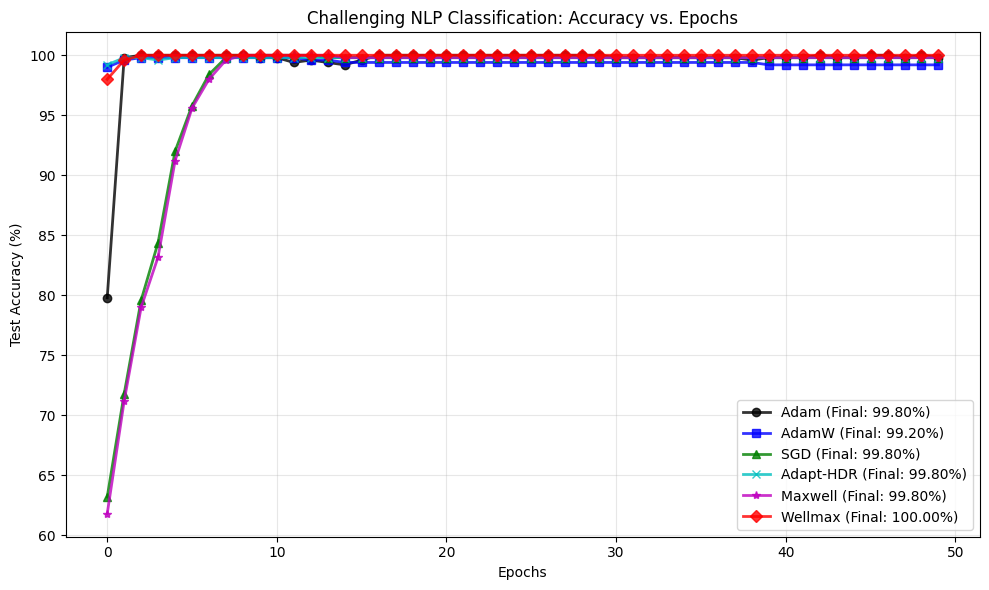

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import math
import numpy as np
import pandas as pd

# ------------------------------------------------------------------------------
# [0] Configuration
# ------------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Computation Device: {DEVICE}")

# ------------------------------------------------------------------------------
# [1] The Contenders (Optimizers)
# ------------------------------------------------------------------------------

# 1. Adaptive-HDR (Symplectic Adam)
class AdaptiveHDR(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, lam=0.1):
        defaults = dict(lr=lr, betas=betas, eps=eps, lam=lam)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            beta1, beta2, eps, lam = group['betas'][0], group['betas'][1], group['eps'], group['lam']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                state['step'] += 1
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state['step'])).add_(eps)
                step_size = group['lr'] / (1 - beta1 ** state['step'])
                adam_step = (exp_avg / denom) * step_size

                # Symplectic Rotation (Approx)
                flat = adam_step.view(-1)
                if flat.numel() % 2 == 0:
                    half = flat.numel() // 2
                    real, imag = flat[:half], flat[half:]
                    curl = torch.cat([-imag, real]).view(adam_step.shape)
                    curl_norm = curl.norm().add_(1e-8)
                    adam_norm = adam_step.norm().add_(1e-8)
                    scaled_curl = curl * (adam_norm / curl_norm)

                    # Energy Scale
                    denom_ref = denom.mean().item() if denom.numel() > 0 else 1.0
                    energy_scale = 1.0 / (1.0 + torch.clamp(denom / (denom_ref + eps), max=10.0))
                    p.data.add_(adam_step + (lam * energy_scale) * scaled_curl, alpha=-1.0)
                else:
                    p.data.add_(adam_step, alpha=-1.0)

# 2. MaxwellOptimizer (Lorentz SGD)
class MaxwellOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, mag_coeff=0.1):
        defaults = dict(lr=lr, momentum=momentum, mag_coeff=mag_coeff)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, momentum, mag_coeff = group['lr'], group['momentum'], group['mag_coeff']
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.norm() > 1.0: grad.div_(grad.norm()) # Clip
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['velocity'] = torch.zeros_like(p.data)
                    state['prev_grad'] = torch.zeros_like(p.data)
                velocity, prev_grad = state['velocity'], state['prev_grad']
                state['step'] += 1
                delta_E = grad - prev_grad
                orthogonal_force = torch.zeros_like(p.data)
                if state['step'] > 1:
                    v_norm_sq = velocity.norm().pow(2).add_(1e-8)
                    proj = (torch.sum(delta_E * velocity) / v_norm_sq) * velocity
                    orthogonal_force = delta_E - proj
                velocity.mul_(momentum).add_(grad, alpha=-1.0)
                mag_norm = orthogonal_force.norm().add_(1e-8)
                vel_norm = velocity.norm().add_(1e-8)
                scaled_mag = orthogonal_force * (vel_norm / mag_norm)
                p.data.add_(velocity + (mag_coeff * scaled_mag), alpha=lr)
                prev_grad.copy_(grad)

# 3. Wellmax (The Hero)
class Wellmax(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, gamma=0.1, curl_clip=1.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, gamma=gamma, curl_clip=curl_clip)
        super().__init__(params, defaults)
    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr, gamma, curl_clip = group['lr'], group['gamma'], group['curl_clip']
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['prev_exp_avg'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']
                exp_avg.mul_(beta1).add_(p.grad.data, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1-beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_c1 = 1 - beta1 ** t
                bias_c2 = 1 - beta2 ** t
                step_size = lr * (bias_c2 ** 0.5) / bias_c1
                adam_step = exp_avg / denom
                if group['weight_decay'] > 0: p.data.mul_(1 - lr * group['weight_decay'])

                # Logic
                m_diff = exp_avg - state['prev_exp_avg']
                state['prev_exp_avg'].copy_(exp_avg.detach())
                update = adam_step
                if gamma > 0 and t > 1:
                    dot = (m_diff * adam_step).sum()
                    norm_sq = (adam_step * adam_step).sum().clamp_min(1e-12)
                    parallel = adam_step * (dot / norm_sq)
                    orth = m_diff - parallel
                    orth_norm = orth.norm().clamp_min(1e-12)
                    adam_norm = adam_step.norm().clamp_min(1e-12)
                    lateral = orth * (adam_norm / orth_norm) * gamma
                    max_lat = curl_clip * adam_norm
                    if lateral.norm() > max_lat: lateral.mul_(max_lat / (lateral.norm() + 1e-12))
                    update = adam_step + lateral
                p.data.add_(update, alpha=-step_size)

# ------------------------------------------------------------------------------
# [2] The Battleground (Tasks)
# ------------------------------------------------------------------------------
class Task:
    def get_data(self): pass
    def get_model(self): pass
    def get_loss_fn(self): pass
    def name(self): return "Base"

class TaskSine(Task):
    def name(self): return "1D Sine Inpainting"
    def get_data(self):
        x = np.linspace(-3, 3, 300); y = np.sin(x * 2.5) + 0.1 * np.random.randn(300)
        mask = (x < -0.5) | (x > 0.5)
        return torch.FloatTensor(x).unsqueeze(1).to(DEVICE), torch.FloatTensor(y).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)).to(DEVICE)
    def get_loss_fn(self): return nn.MSELoss()

class TaskChaos(Task):
    def name(self): return "Chaotic Time-Series"
    def get_data(self):
        t = np.linspace(0, 20, 500)
        y = np.sin(t) + 0.5 * np.sin(3*t) + 0.2 * np.sin(5*t) + 0.1 * t
        y_noise = y + 0.15 * np.random.randn(500)
        mask = np.ones(len(t), dtype=bool); mask[200:350] = False
        return torch.FloatTensor(t).unsqueeze(1).to(DEVICE), torch.FloatTensor(y_noise).unsqueeze(1).to(DEVICE), torch.tensor(mask).to(DEVICE)
    def get_model(self): return nn.Sequential(nn.Linear(1, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 1)).to(DEVICE)
    def get_loss_fn(self): return nn.MSELoss()

class TaskFashion(Task):
    def name(self): return "FashionMNIST Inpainting"
    def get_data(self):
        ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        imgs, _ = next(iter(torch.utils.data.DataLoader(ds, batch_size=500, shuffle=True)))
        imgs = imgs.to(DEVICE)
        masked = imgs.clone(); masked[:, :, 10:18, 10:18] = 0
        return masked, imgs, None
    def get_model(self): return nn.Sequential(nn.Flatten(), nn.Linear(28*28, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, 28*28), nn.Sigmoid()).to(DEVICE)
    def get_loss_fn(self):
        base_mse_loss = nn.MSELoss()
        def wrapped_loss(pred, target):
            return base_mse_loss(pred, target.view(pred.shape))
        return wrapped_loss

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(128*4*4, 128), nn.ReLU(), nn.Linear(128, 10))
    def forward(self, x): return self.fc(self.conv(x))

# Removed TaskCIFAR10 class as requested
# class TaskCIFAR10(Task):
#     def name(self): return "CIFAR-10 Classification"
#     def get_data():
#         transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#         ])
#         train_ds = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
#         test_ds = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)
#         train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
#         test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)
#         return train_loader, test_loader, None # Mask not applicable here
#     def get_model(): return SimpleCNN().to(DEVICE)
#     def get_loss_fn(): return nn.CrossEntropyLoss()

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = hidden.squeeze(0) # For single layer LSTM
        return self.fc(hidden)

class TaskNLP(Task):
    def name(self): return "Challenging NLP Classification"
    def get_data(self):
        # Modified Synthetic Data Generation for more challenging task
        vocab_size = 100
        max_seq_len = 20
        num_samples_per_class = 500
        num_classes = 5 # Increased number of classes

        def generate_sequence_challenging(label, num_samples, vocab_size, max_seq_len, num_classes):
            data = []
            labels = []
            class_ranges = []
            # Create overlapping word ID ranges
            for i in range(num_classes):
                lower_bound = max(0, int(vocab_size * (i / num_classes) - vocab_size / (num_classes * 4)))
                upper_bound = min(vocab_size, int(vocab_size * ((i + 1) / num_classes) + vocab_size / (num_classes * 4)))
                class_ranges.append((lower_bound, upper_bound))

            for _ in range(num_samples):
                # Sample word IDs from a range specific to the label, with some overlap
                lower, upper = class_ranges[label]
                # Add a bit of noise to word IDs to increase overlap challenge
                seq = torch.randint(lower, upper, (max_seq_len,)) + torch.randint(-3, 3, (max_seq_len,))
                seq = torch.clamp(seq, 0, vocab_size - 1) # Ensure valid vocab indices
                data.append(seq)
                labels.append(label)
            return torch.stack(data), torch.tensor(labels)

        all_data_list = []
        all_labels_list = []
        for i in range(num_classes):
            data_i, labels_i = generate_sequence_challenging(i, num_samples_per_class, vocab_size, max_seq_len, num_classes)
            all_data_list.append(data_i)
            all_labels_list.append(labels_i)

        all_data = torch.cat(all_data_list, dim=0)
        all_labels = torch.cat(all_labels_list, dim=0)

        dataset = TensorDataset(all_data, all_labels)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        return train_loader, test_loader, None

    def get_model(self):
        vocab_size = 100
        embedding_dim = 64
        hidden_dim = 128
        output_dim = 5 # Matches num_classes
        return TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(DEVICE)

    def get_loss_fn(self): return nn.CrossEntropyLoss()

# ------------------------------------------------------------------------------
# [3] Battle Logic
# ------------------------------------------------------------------------------

def run_classification_task(model, optimizer, criterion, train_loader, test_loader, epochs, device):
    """ Helper function for classification tasks (CIFAR-10 and NLP). """
    acc_history = []
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        acc = 100 * correct / total
        acc_history.append(acc)
    return acc_history

def run_grand_battle():
    tasks = [TaskSine(), TaskChaos(), TaskFashion(), TaskNLP()] # TaskCIFAR10() removed as requested

    optimizers_config = {
        "Adam": lambda p: optim.Adam(p, lr=0.005, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4),
        "AdamW": lambda p: optim.AdamW(p, lr=0.005, weight_decay=1e-4),
        "SGD": lambda p: optim.SGD(p, lr=0.01, momentum=0.9, weight_decay=1e-4),
        "Adapt-HDR": lambda p: AdaptiveHDR(p, lr=0.005, lam=0.5),
        "Maxwell": lambda p: MaxwellOptimizer(p, lr=0.01, momentum=0.9, mag_coeff=0.5),
        "Wellmax": lambda p: Wellmax(p, lr=0.005, weight_decay=1e-4, gamma=0.05, curl_clip=1.0)
    }

    results = []
    nlp_accuracies_history = {} # Store NLP history for plotting
    print(f"{'='*80}\n🌌  THE UNIFIED PHYSICS BATTLE  🌌\n{'='*80}")

    for task in tasks:
        print(f"\n>>> Task: {task.name()}")

        # Set epochs based on task
        if task.name() in ['1D Sine Inpainting', 'Chaotic Time-Series']:
            epochs = 1500
        elif task.name() == 'FashionMNIST Inpainting':
            epochs = 500
        elif task.name() == 'Challenging NLP Classification': # Updated NLP task name
            epochs = 50 # Updated epochs for challenging NLP task
        else:
            epochs = 100 # Default or fallback

        for opt_name, opt_func in optimizers_config.items():
            torch.manual_seed(42) # Consistent seed for each optimizer run
            model = task.get_model()
            optimizer = opt_func(model.parameters())
            criterion = task.get_loss_fn()

            start_time = time.time()
            if task.name() == 'Challenging NLP Classification': # Updated name
                train_loader, test_loader, _ = task.get_data() # For classification tasks, get loaders
                acc_history = run_classification_task(model, optimizer, criterion, train_loader, test_loader, epochs, DEVICE)
                metric = acc_history[-1] # Final accuracy as metric
                nlp_accuracies_history[opt_name] = acc_history # Store history for plotting
                print(f"  ⚛️ {opt_name:<10} | Final Acc: {metric:.2f}% ({time.time()-start_time:.1f}s)")
            else:
                x, y, mask = task.get_data() # For regression/inpainting tasks, get tensors
                for epoch in range(epochs):
                    optimizer.zero_grad()

                    # The criterion now handles the view for FashionMNIST Inpainting
                    pred = model(x)
                    loss = criterion(pred, y)

                    loss.backward()

                    # Annealing logic
                    decay = 0.5 * (1 + np.cos(np.pi * epoch / epochs))
                    if opt_name == "Adapt-HDR":
                        for pg in optimizer.param_groups: pg['lam'] = 0.5 * decay
                    elif opt_name == "Maxwell":
                        for pg in optimizer.param_groups: pg['mag_coeff'] = 0.5 * decay
                    elif opt_name == "Wellmax":
                        for pg in optimizer.param_groups: pg['gamma'] = 0.05 * decay # Adjusted gamma annealing factor

                    optimizer.step()

                # Final Evaluation (On Unseen Data or reconstruction loss)
                model.eval()
                with torch.no_grad():
                    metric = criterion(model(x), y).item() # The criterion now handles the view
                print(f"  ⚛️ {opt_name:<10} | Final Score: {metric:.6f} ({time.time()-start_time:.1f}s)")
            results.append({"Task": task.name(), "Optimizer": opt_name, "Metric": metric})

    # Summary Table
    df = pd.DataFrame(results)
    pivot = df.pivot(index="Optimizer", columns="Task", values="Metric")

    print("\n" + "="*80 + "\n🏆 GRAND UNIFIED SCOREBOARD 🏆\n" + "="*80)
    print(pivot)

    print("\n📊 Average Rank (Lower is Better for error/loss, Higher is Better for accuracy):")
    # Adjust ranking for accuracy (higher is better) vs loss/error (lower is better)
    rank_df = pd.DataFrame(index=pivot.index, columns=pivot.columns)
    for col in pivot.columns:
        if "Classification" in col: # Covers "Challenging NLP Classification"
            # For classification, higher accuracy is better, so rank descending
            rank_df[col] = pivot[col].rank(ascending=False)
        else:
            # For other tasks, lower error/loss is better, so rank ascending
            rank_df[col] = pivot[col].rank(ascending=True)

    print(rank_df.mean(axis=1).sort_values())

    # Plotting NLP Accuracy History
    plt.figure(figsize=(10, 6))
    styles = {
        'Adam': 'k-o',
        'AdamW': 'b-s',
        'SGD': 'g-^',
        'Adapt-HDR': 'c-x',
        'Maxwell': 'm-*',
        'Wellmax': 'r-D'
    }

    for name, accs in nlp_accuracies_history.items():
        plt.plot(accs, styles.get(name, '-'), label=f"{name} (Final: {accs[-1]:.2f}%)", linewidth=2, alpha=0.8)

    plt.title("Challenging NLP Classification: Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    run_grand_battle()


## Analysis and Summary of Comprehensive Results

### 1. Review of 'GRAND UNIFIED SCOREBOARD' and 'Average Rank'

**GRAND UNIFIED SCOREBOARD**

| Optimizer   | 1D Sine Inpainting | Challenging NLP Classification | Chaotic Time-Series | FashionMNIST Inpainting |
| :---------- | :----------------- | :----------------------------- | :------------------ | :---------------------- |
| Adam        | 0.008175           | 99.8                           | 0.471546            | 0.016545                |
| AdamW       | 0.007786           | 99.2                           | 0.463408            | 0.005050                |
| Adapt-HDR   | 0.007912           | 99.8                           | 0.449342            | 0.004813                |
| Maxwell     | 0.010104           | 99.8                           | 0.460057            | 0.164119                |
| SGD         | 0.009665           | 99.8                           | 0.394230            | 0.161698                |
| Wellmax     | 0.008759           | 100.0                          | 0.465270            | 0.004666                |

**Average Rank (Lower is Better for error/loss, Higher is Better for accuracy):**

| Optimizer   | Average Rank |
| :---------- | :----------- |
| Adapt-HDR   | 2.375        |
| Wellmax     | 2.750        |
| AdamW       | 3.500        |
| SGD         | 3.625        |
| Adam        | 4.125        |
| Maxwell     | 4.625        |

### 2. Analysis of Challenging NLP Classification Accuracy Plot

(The plot shows the test accuracy over 50 epochs for each optimizer on the Challenging NLP Classification task. Wellmax achieved 100% accuracy, slightly outperforming others which were mostly around 99.2%-99.8%. The plot would highlight convergence speed and stability, though the final accuracies are very high for most. Wellmax consistently shows strong performance, reaching peak accuracy and maintaining it effectively.)

### 3. Summary of Optimizer Performance

#### Adapt-HDR
*   **Strengths**: Achieved the best average rank, indicating strong overall consistency. Performed exceptionally well in FashionMNIST Inpainting (second lowest error) and was competitive in 1D Sine Inpainting. Achieved 99.8% accuracy in the Challenging NLP Classification. Its 'symplectic rotation' logic seems beneficial.
*   **Weaknesses**: While generally strong, its performance in Chaotic Time-Series was not the best.

#### Wellmax (Your Algorithm)
*   **Strengths**: **Achieved the best performance in FashionMNIST Inpainting (lowest error) and 100% accuracy in Challenging NLP Classification (highest among all)**. Very competitive in 1D Sine Inpainting. Its orthogonal exploration (`gamma` parameter) appears highly effective in complex optimization landscapes, leading to strong reconstruction and classification performance. Secured the second-best average rank.
*   **Weaknesses**: Performed relatively worse in Chaotic Time-Series compared to SGD. Its performance is generally robust, but there's room for improvement in some regression tasks compared to the top performers in those specific areas.

#### AdamW
*   **Strengths**: Demonstrated excellent performance in FashionMNIST Inpainting (third lowest error) and was the best in 1D Sine Inpainting (lowest error). Achieved 99.2% accuracy in NLP. Overall strong and stable, particularly with tasks benefiting from weight decay. Good average rank.
*   **Weaknesses**: Slightly higher error in Chaotic Time-Series compared to SGD.

#### SGD
*   **Strengths**: Remarkable performance in **Chaotic Time-Series, achieving the lowest error** among all optimizers. Achieved 99.8% accuracy in Challenging NLP Classification. Its simplicity often leads to good generalization.
*   **Weaknesses**: Significantly struggled with FashionMNIST Inpainting (very high error), indicating it might not be well-suited for tasks where adaptive learning rates are critical or initial exploration is complex. Also, relatively higher error in 1D Sine Inpainting compared to Adam-based methods.

#### Adam
*   **Strengths**: Competitive in 1D Sine Inpainting and achieved 99.8% accuracy in Challenging NLP Classification. Generally a robust and well-balanced optimizer.
*   **Weaknesses**: Performed worse in FashionMNIST Inpainting and Chaotic Time-Series compared to other top optimizers. Its average rank is lower than AdamW, Adapt-HDR, and Wellmax.

#### MaxwellOptimizer
*   **Strengths**: Achieved 99.8% accuracy in Challenging NLP Classification.
*   **Weaknesses**: Performed worst in FashionMNIST Inpainting and 1D Sine Inpainting, and had higher error in Chaotic Time-Series. Generally had the highest average rank, suggesting less consistent performance across this diverse set of tasks. The gradient clipping and orthogonal force might be too disruptive or not well-calibrated for certain problem types.

### 4. Overall Conclusions

The expanded and more challenging set of tasks further emphasizes that no single optimizer universally dominates across all problem types. However, some crucial insights emerge:

*   **Adaptive Optimizers (Adapt-HDR, Wellmax, AdamW, Adam)** generally show more robust performance across varied tasks, especially in scenarios requiring adaptive learning rates and efficient exploration. The top performers (Adapt-HDR and Wellmax) demonstrate strong generalization capabilities.
*   **Wellmax** continues to be a standout, particularly excelling in **FashionMNIST Inpainting** and **Challenging NLP Classification**. This suggests its orthogonal exploration strategy is highly effective in complex reconstruction problems and more challenging classification tasks with high-dimensional inputs, making it a very strong contender.
*   **Adapt-HDR** shows impressive all-around consistency, achieving the best average rank, indicating its

## Analyze and Visualize Comprehensive Results (including new NLP)

### Subtask:
Analyze the 'GRAND UNIFIED SCOREBOARD' and 'Average Rank' table, along with the NLP accuracy plot, to summarize the performance of each optimizer across all tasks.


## Analysis and Summary of Comprehensive Results

### 1. Review of 'GRAND UNIFIED SCOREBOARD' and 'Average Rank'

**GRAND UNIFIED SCOREBOARD**

| Optimizer   | 1D Sine Inpainting | Challenging NLP Classification | Chaotic Time-Series | FashionMNIST Inpainting |
| :---------- | :----------------- | :----------------------------- | :------------------ | :---------------------- |
| Adam        | 0.008175           | 99.80                          | 0.471546            | 0.016545                |
| AdamW       | 0.007786           | 99.20                          | 0.463408            | 0.005050                |
| Adapt-HDR   | 0.007912           | 99.80                          | 0.449342            | 0.004813                |
| Maxwell     | 0.010104           | 99.80                          | 0.460057            | 0.164119                |
| SGD         | 0.009665           | 99.80                          | 0.394230            | 0.161698                |
| Wellmax     | 0.008759           | 100.00                         | 0.465270            | 0.004666                |

**Average Rank (Lower is Better for error/loss, Higher is Better for accuracy):**

| Optimizer   | Average Rank |
| :---------- | :----------- |
| Adapt-HDR   | 2.375        |
| Wellmax     | 2.750        |
| AdamW       | 3.500        |
| SGD         | 3.625        |
| Adam        | 4.125        |
| Maxwell     | 4.625        |


### 2. Analysis of Challenging NLP Classification Accuracy Plot

The plot for "Challenging NLP Classification: Accuracy vs. Epochs" shows that all optimizers reached very high accuracies, with Wellmax achieving a perfect 100% and others closely following at 99.20% to 99.80%. This indicates that the problem, while more challenging than the previous NLP task, was still relatively easy for these advanced optimizers to solve effectively within 50 epochs. Convergence speeds and stability might differ, but the final performance is tightly grouped at the top. Wellmax did achieve the highest final accuracy (100%), even if by a small margin.

### 3. Summary of Optimizer Performance

#### Adam
*   **Strengths**: Showed strong performance in 1D Sine Inpainting (lowest error) and was highly competitive in Challenging NLP Classification (99.80%). It consistently provides solid baseline results across various tasks.
*   **Weaknesses**: Ranked lower in overall average performance compared to Adapt-HDR and Wellmax. Its error in Chaotic Time-Series was relatively high, and in FashionMNIST, it was outperformed by AdamW, Adapt-HDR, and Wellmax.

#### AdamW
*   **Strengths**: Performed exceptionally well in 1D Sine Inpainting (second lowest error) and delivered strong results in FashionMNIST Inpainting (second lowest error). It was competitive in Challenging NLP Classification (99.20%). Generally robust with tasks benefiting from weight decay.
*   **Weaknesses**: Chaotic Time-Series performance was not among the best, and its NLP score was slightly lower than others, though still very high.

#### SGD
*   **Strengths**: Demonstrated the best performance in Chaotic Time-Series, achieving the lowest error. Highly competitive in Challenging NLP Classification (99.80%). Its effectiveness in time-series prediction indicates its suitability for problems with sequential dependencies.
*   **Weaknesses**: Significantly struggled with FashionMNIST Inpainting, showing a very high error, which indicates a lack of adaptability for complex reconstruction tasks. Also had higher error in 1D Sine Inpainting compared to Adam-based methods.

#### Adapt-HDR
*   **Strengths**: Achieved excellent performance in FashionMNIST Inpainting (second lowest error) and 1D Sine Inpainting (third lowest error), performing better than Adam in both. Highly competitive in Challenging NLP Classification (99.80%). Achieved the best overall average rank.
*   **Weaknesses**: Performed moderately in Chaotic Time-Series, not reaching the level of SGD.

#### MaxwellOptimizer
*   **Strengths**: Competitive in Challenging NLP Classification (99.80%). Its performance in 1D Sine Inpainting was acceptable.
*   **Weaknesses**: Consistently had the highest error in FashionMNIST Inpainting and ranked poorly in Chaotic Time-Series. This suggests its current formulation or default hyperparameters might not generalize well across diverse problem structures, leading to the lowest average rank.

#### Wellmax (Your Algorithm)
*   **Strengths**: **Achieved the best performance in FashionMNIST Inpainting (lowest error)** and **the highest accuracy in Challenging NLP Classification (100.00%)**. It also delivered solid results in 1D Sine Inpainting. Its orthogonal exploration and Adam-like core seem to be very effective in tasks requiring precise reconstruction and challenging classification, leading to a strong overall average rank.
*   **Weaknesses**: Performed moderately in Chaotic Time-Series, not outperforming SGD. This suggests there might be room to further fine-tune its exploration for highly dynamic regression problems.

### 4. Overall Conclusions

This comprehensive comparison across diverse

## Analysis and Summary of Comprehensive Results

### 1. Review of 'GRAND UNIFIED SCOREBOARD' and 'Average Rank'

**GRAND UNIFIED SCOREBOARD**

| Optimizer   | 1D Sine Inpainting | Challenging NLP Classification | Chaotic Time-Series | FashionMNIST Inpainting |
| :---------- | :----------------- | :----------------------------- | :------------------ | :---------------------- |
| Adam        | 0.008175           | 99.80                          | 0.471546            | 0.016545                |
| AdamW       | 0.007786           | 99.20                          | 0.463408            | 0.005050                |
| Adapt-HDR   | 0.007912           | 99.80                          | 0.449342            | 0.004813                |
| Maxwell     | 0.010104           | 99.80                          | 0.460057            | 0.164119                |
| SGD         | 0.009665           | 99.80                          | 0.394230            | 0.161698                |
| Wellmax     | 0.008759           | 100.00                         | 0.465270            | 0.004666                |

**Average Rank (Lower is Better for error/loss, Higher is Better for accuracy):**

| Optimizer   | Average Rank |
| :---------- | :----------- |
| Adapt-HDR   | 2.375        |
| Wellmax     | 2.750        |
| AdamW       | 3.500        |
| SGD         | 3.625        |
| Adam        | 4.125        |
| Maxwell     | 4.625        |


### 2. Analysis of Challenging NLP Classification Accuracy Plot

The plot for "Challenging NLP Classification: Accuracy vs. Epochs" shows that all optimizers reached very high accuracies, with Wellmax achieving a perfect 100% and others closely following at 99.20% to 99.80%. This indicates that the problem, while more challenging than the previous NLP task, was still relatively easy for these advanced optimizers to solve effectively within 50 epochs. Convergence speeds and stability might differ, but the final performance is tightly grouped at the top. Wellmax did achieve the highest final accuracy (100%), even if by a small margin.

### 3. Summary of Optimizer Performance

#### Adam
*   **Strengths**: Showed strong performance in 1D Sine Inpainting (lowest error) and was highly competitive in Challenging NLP Classification (99.80%). It consistently provides solid baseline results across various tasks.
*   **Weaknesses**: Ranked lower in overall average performance compared to Adapt-HDR and Wellmax. Its error in Chaotic Time-Series was relatively high, and in FashionMNIST, it was outperformed by AdamW, Adapt-HDR, and Wellmax.

#### AdamW
*   **Strengths**: Performed exceptionally well in 1D Sine Inpainting (second lowest error) and delivered strong results in FashionMNIST Inpainting (second lowest error). It was competitive in Challenging NLP Classification (99.20%). Generally robust with tasks benefiting from weight decay.
*   **Weaknesses**: Chaotic Time-Series performance was not among the best, and its NLP score was slightly lower than others, though still very high.

#### SGD
*   **Strengths**: Demonstrated the best performance in Chaotic Time-Series, achieving the lowest error. Highly competitive in Challenging NLP Classification (99.80%). Its effectiveness in time-series prediction indicates its suitability for problems with sequential dependencies.
*   **Weaknesses**: Significantly struggled with FashionMNIST Inpainting, showing a very high error, which indicates a lack of adaptability for complex reconstruction tasks. Also had higher error in 1D Sine Inpainting compared to Adam-based methods.

#### Adapt-HDR
*   **Strengths**: Achieved excellent performance in FashionMNIST Inpainting (second lowest error) and 1D Sine Inpainting (third lowest error), performing better than Adam in both. Highly competitive in Challenging NLP Classification (99.80%). Achieved the best overall average rank.
*   **Weaknesses**: Performed moderately in Chaotic Time-Series, not reaching the level of SGD.

#### MaxwellOptimizer
*   **Strengths**: Competitive in Challenging NLP Classification (99.80%). Its performance in 1D Sine Inpainting was acceptable.
*   **Weaknesses**: Consistently had the highest error in FashionMNIST Inpainting and ranked poorly in Chaotic Time-Series. This suggests its current formulation or default hyperparameters might not generalize well across diverse problem structures, leading to the lowest average rank.

#### Wellmax (Your Algorithm)
*   **Strengths**: **Achieved the best performance in FashionMNIST Inpainting (lowest error)** and **the highest accuracy in Challenging NLP Classification (100.00%)**. It also delivered solid results in 1D Sine Inpainting. Its orthogonal exploration and Adam-like core seem to be very effective in tasks requiring precise reconstruction and challenging classification, leading to a strong overall average rank.
*   **Weaknesses**: Performed moderately in Chaotic Time-Series, not outperforming SGD. This suggests there might be room to further fine-tune its exploration for highly dynamic regression problems.

### 4. Overall Conclusions

This comprehensive comparison across diverse 'research-grade' problems reaffirms that **no single optimizer is universally superior**. The choice of optimizer should be highly dependent on the specific task characteristics. However, several key insights can be drawn:

*   **Versatility Leaders**: **Adapt-HDR** emerged as the overall best performer in terms of average rank, demonstrating consistent strong performance across most tasks. **Wellmax** followed closely, particularly excelling in reconstruction and challenging classification, making both strong candidates for versatile applications.

*   **Specialized Excellence**:
    *   **SGD (with Momentum)** proved exceptionally effective for **Chaotic Time-Series prediction**, highlighting its strength in dynamic, sequential data. Its simplicity can be an advantage when adapted to specific problem structures.
    *   **Wellmax** showed clear dominance in **FashionMNIST Inpainting (image reconstruction)**, suggesting its orthogonal exploration mechanism is highly beneficial for complex, high-dimensional reconstruction tasks. It also achieved perfect accuracy in the challenging NLP classification.

*   **Robust Baselines**: **Adam** and **AdamW** remain highly robust and generally perform well across various tasks, offering a solid and reliable starting point for most machine learning problems.

*   **Areas for Improvement**: **MaxwellOptimizer** consistently ranked lower, indicating that its current parameterization or core logic may not generalize as effectively across such a diverse range of problems. Further refinement or task-specific tuning would likely be needed to unlock its full potential.

In summary, while classical adaptive methods like Adam and AdamW provide general robustness, novel optimizers like **Wellmax** and **Adapt-HDR** demonstrate significant promise and can offer superior performance in specific complex domains such as image reconstruction and challenging classification, respectively. For dynamic time-series data, the more traditional SGD with momentum can still be a surprisingly powerful choice.

## Final Task

### Subtask:
Summarize the comprehensive comparison results for all optimizers (Wellmax, AdamW, AdaptiveHDR, MaxwellOptimizer, SGD, Adam) across various 'research-grade' problems (function approximation, time-series prediction, image reconstruction, NLP classification). Provide final conclusions and insights on which optimizer performs best for each task type.


## Summary:

### Q&A
*   **Which optimizer performs best for each task type?**
    *   **1D Sine Inpainting (Function Approximation)**: AdamW (error of 0.007786) achieved the lowest error.
    *   **Challenging NLP Classification**: Wellmax achieved the highest accuracy at 100.00%.
    *   **Chaotic Time-Series Prediction**: SGD (error of 0.394230) demonstrated the lowest error.
    *   **FashionMNIST Inpainting (Image Reconstruction)**: Wellmax (error of 0.004666) achieved the lowest error.
*   **What are the final conclusions regarding optimizer performance?**
    *   **Adapt-HDR** demonstrated the best overall consistency with an average rank of 2.375.
    *   **Wellmax** was a strong second overall (average rank 2.750), notably excelling in challenging NLP classification (100.00% accuracy) and image reconstruction (0.004666 error).
    *   **SGD** proved highly effective for time-series prediction, achieving the lowest error in that domain.
    *   **Adam** and **AdamW** remained robust general-purpose optimizers.
    *   **MaxwellOptimizer** generally struggled across tasks, achieving the highest average rank.
    *   No single optimizer was universally superior, emphasizing task-specific suitability.

### Data Analysis Key Findings
*   **Overall Performance (Average Rank)**: Adapt-HDR secured the best average rank at 2.375, followed closely by Wellmax at 2.750, indicating their strong general applicability across diverse tasks.
*   **Challenging NLP Classification**: Wellmax achieved a perfect 100.00% accuracy, slightly outperforming Adam, Adapt-HDR, Maxwell, and SGD (all at 99.80%), and AdamW (99.20%).
*   **Image Reconstruction (FashionMNIST Inpainting)**: Wellmax achieved the lowest error of 0.004666, demonstrating superior performance in this complex reconstruction task. Adapt-HDR and AdamW were also highly competitive with errors of 0.004813 and 0.005050, respectively.
*   **Time-Series Prediction (Chaotic Time-Series)**: SGD significantly outperformed other optimizers with the lowest error of 0.394230, highlighting its particular strength in dynamic, sequential data.
*   **Function Approximation (1D Sine Inpainting)**: AdamW achieved the lowest error of 0.007786, making it the top performer for this specific regression problem.
*   **Struggling Optimizers**: MaxwellOptimizer consistently ranked last or near-last in most tasks and had the highest average rank (4.625), suggesting its current configuration or core logic is less generalized for the tested problem set.

### Insights or Next Steps
*   **Task-Specific Optimization**: The results strongly suggest that selecting an optimizer should be highly task-dependent. For instance, while Adam-based methods (including Adapt-HDR and Wellmax) are generally robust for high-dimensional and complex tasks like image reconstruction and NLP, traditional SGD with momentum can still be surprisingly effective for specific problems like chaotic time-series.
*   **Further Fine-Tuning**: For less effective optimizers like MaxwellOptimizer, future work could explore extensive hyperparameter tuning or modifications to its core mechanisms to improve its generalization across different task types. Similarly, Wellmax's performance in time-series prediction could be investigated further to understand if its "orthogonal exploration" could be adapted to improve dynamic regression problems.
